In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

import sklearn
from sklearn.feature_selection import VarianceThreshold


from imblearn.over_sampling import SMOTE
from collections import Counter

from scipy.stats import kendalltau

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [ ]:
# load the kaggle.json data.
from google.colab import files
kaggle = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#load the dataset from the kaggle : https://www.kaggle.com/c/santander-customer-satisfaction/data
!mkdir kaggle # create kaggle directory

!cp kaggle.json ~/.kaggle/ # copy the kggle.json into kaggle directory
!chmod 600 ~/.kaggle/kaggle.json # changing the operation
!kaggle competitions download -c santander-customer-satisfaction # download the dataset by using the kaggle api

mkdir: cannot create directory ‘kaggle’: File exists
  0% 0.00/4.05M [00:00<?, ?B/s]
100% 4.05M/4.05M [00:00<00:00, 37.4MB/s]
  0% 0.00/4.02M [00:00<?, ?B/s]
100% 4.02M/4.02M [00:00<00:00, 132MB/s]
  0% 0.00/612k [00:00<?, ?B/s]
100% 612k/612k [00:00<00:00, 198MB/s]


In [ ]:
# unzip the data and load the data 
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
def dataset_analysis(df):
  """
   this function takes dataframe as input and gives some description and details are generated.
  """
  print("This dataset having {0} rows and {1} columns.".format(df.shape[0],df.shape[1]))
  int_cols=[]
  float_cols = []
  obj_cols=[]
  for i in df.columns[:]:
    if df[i].dtype == "int":
      int_cols.append(i)
    elif df[i].dtype == "float":
        float_cols.append(i)
    else:
        obj_cols.append(i)
    
  print("dataset have {0} integer type & {1} float type & {2} object type".format(len(int_cols),len(float_cols),len(obj_cols)))
  print("-"*50)
  print(df.info())
  print("-"*50)
  #print(df.head(3))
  #df.head(3)
  #print(df.describe())


In [ ]:
def missingdata_pts(df):
  """
     this function takes dataframe as input and check there is any missing /Nan values are existed in that dataframe.
  """
  # check the missing values in the given dataset.
  print("the missing values in the given dataset is {0}.".format(df.isna().sum().sum()))

In [ ]:
def constant_features(df):
  """
    Constant Feature: Same value in all the records. 
    it takes dataframe as input and remove the constant features because those kind of features are not useful for classification.
  """
  constant_columns = []
  for i in df.columns[:]:
    if df[i].nunique() == 1:
      constant_columns.append(i)
  print("{0} of constant features in the given dataframe".format(len(constant_columns)))
  return constant_columns

In [ ]:
def quasiconstant_features(df):
  """
  Quasi Constant Feature: One of the values is dominant 99.9%.
  """
  import sklearn
  from sklearn.feature_selection import VarianceThreshold
  a = VarianceThreshold(threshold=0.01)
  a.fit(df)
  quasi_columns = df.columns[:][~a.get_support()]
  print("The no of quasiconstant features in the given dataframe:{}".format(len(quasi_columns)))
  return quasi_columns


In [ ]:
def duplicate_feature_removal(df):
  """
     this function takes dataframe as input and remove the duplicated valued features.
  """
  # drop the duplicated features in terms of names and values.
  a=df.shape[1]
  #A.T.drop_duplicates(keep="last").T
  df = df.T.drop_duplicates(keep="first").T
  c= df.shape[1]
  print("The no of duplicated columns are removed having same values : ",(a-c))
  return df

In [ ]:
def column_analysis(df,col):
  """ this function to analyze the  column on given dataframe"""
  plt.figure(figsize=(16,4))
  plt.subplot(1,3,1)
  """
    The pie chart is also the same as the countplot, 
    only gives you additional information about the percentage presence of each category in data 
    means which category is getting how much weightage in data.
  """
  df[col].value_counts().plot.pie(autopct="%1.2f%%",shadow=True)
  plt.title("%contribution of{0}".format(col))

  plt.subplot(1,3,2)
  """
     Countplot is basically a count of frequency plot in form of a bar graph. 
     It plots the count of each category in a separate bar. 
     When we use the pd value counts function on any column, 
     It is the same visual form of the value counts function.
  """
  
  sns.countplot(df[col])
  plt.title("#ofvalues in {0}".format(col))
  plt.legend(["satisfied","unsatisfied"])

  plt.subplot(1,3,3)
  plt.title("distribution of {0}".format(col))
  """
    Distplot is also known as the second Histogram 
    because it is a slight improvement version of the Histogram. 
    Distplot gives us a KDE(Kernel Density Estimation) over
    histogram which explains PDF(Probability Density Function) 
    which means what is the probability of each value occurring in this column.
  """
  sns.distplot(df[col])
  plt.legend(["satisfied","unsatisfied"])
  plt.show()


In [ ]:
# based on my experiment I found some features/columns having the outlier points.
def feature_outlier_analysis(df,col):
  """
    this function takes dataframe&column as input.
    gives some basic intution about that column from the plots.
  """
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  sns.boxplot(y=df[col])
  print("the no of unique columns in the column : {0}".format(df[col].nunique()))
  plt.subplot(1,2,2)
  df[col].value_counts().plot.pie(autopct='%1.3f%%',shadow=True)
  plt.show()

  #calculating 0-100th percentile to find a the correct percentile value for removal of outliers
  print("0-100th percentile".center(50,"="))
  for i in range(0,100,10):
    var =df[col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
  print ("100 percentile value is ",var[-1])

  print("90-100th percentile".center(50,"="))
  #looking further from the 99th percecntile
  for i in range(90,100):
    var =df[col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
  print ("100 percentile value is ",var[-1])
  
  print("99-100th percentile ".center(50,"="))
  #calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
  for i in np.arange(0.0, 1.0, 0.1):
    var = df[col].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
  print("100 percentile value is ",var[-1])
  print("analyse the values ".center(50,"="))
  print(df[col].value_counts())

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/06/exploratory-data-analysis-using-data-visualization-techniques/
def univariate_analysis(df,target,col):
  """ this function helps to analyze the single column . and How it will helpful to the classification/Target prediction
      it takes dataframe and target and column name as inputs.
  """
  # # create new dataframe with all the points having Target 1
  tu1 = df[df[target]==1] # this dataframe is completly having unsatisfied customers.
  # create new dataframe with all the points having target 0.
  ts0 = df[df[target]==0] # this dataframe contains the saisfied customers.

  plt.figure(figsize=(10,10)) 
  """
     univariate scatter plot takes values on x-axis and zero on other axis
  """
  plt.subplot(2,3,1)
  plt.plot(tu1[col],np.zeros_like(tu1[col]),"r*") # on x axis consider values and on y axis takes all are zero's
  plt.plot(ts0[col],np.zeros_like(ts0[col]),"b-") # on x axis consider values and on y axis takes all are zero's
  plt.title("scattered {}".format(col))
  plt.legend(["1UNsatisfied","0satisfied"])
  plt.xlabel("{}".format(col))
  
  """
    histogram
    it gives the counts on one axis and actual values on other axis.

  """
  plt.subplot(2,3,2)
  plt.hist([tu1[col], ts0[col]], color=['r','b'])
  plt.title("histogram of {}".format(col))
  plt.legend(["1unsatisfied","0satisfied"])
  plt.xlabel("{}".format(col))
  plt.ylabel("count")

  """
  # 1-d distribution plot

     # facetgrid Initialize the matplotlib figure and FacetGrid object.
     # it maps a dataset onto multiple axes arrayed in a grid of rows and columns that corresponds to the variables in the dataset.
     #you can also use multiple grids also  like below.
     #PairGrid : Subplot grid for plotting pairwise relationships.
     #relplot : Combine a relational plot and a :class:`FacetGrid`.
     #catplot : Combine a categorical plot and a :class:`FacetGrid`.
     #lmplot : Combine a regression plot and a :class:`FacetGrid`.
  """
  plt.subplot(2,3,3)
  #sns.set_style("whitegrid")
  #sns.FacetGrid(df, hue=target,height=3).map(sns.distplot,col).add_legend()
  #sns.distplot(df[col],hue=target)
  sns.distplot(tu1[col], hist=False, color="red") 
  sns.distplot(ts0[col], hist=False, color="blue")

  plt.title("1-d distribution of {}".format(col))
  plt.legend(["1unsatisfied","0satisfied"])
  plt.xlabel("{}".format(col))
  """
    scatterplot:To plot the relationship between two/more numerical variables
  """
  plt.subplot(2,3,4)
  sns.scatterplot(x=df[col],y=df[target],color="red")
  #sns.barplot(df[col], df[target])
  plt.title("2-dscatter{0}vs{1}".format(col,target))
  #plt.legend(["1unsatisfied","0satisfied"])
  
  """
    Boxplot: it explains 

    Median – Middle value in series after sorting
    Percentile – Gives any number which is number of values present before 
    this percentile like for example 50 under 25th percentile so it explains total of 50 values are there below 25th percentile
    Minimum and Maximum – These are not minimum and maximum values, 
    rather they describe the lower and upper boundary of standard deviation which is calculated using Interquartile range(IQR).
           
  """
  my_colors=["red","blue"]
  plt.subplot(2,3,5)
  sns.set_palette(my_colors)
  sns.boxplot(y=df[col],x=df[target])
  plt.title("{0} vs {1}".format(target,col))
  plt.legend(["1unsatisfied","0satisfied"])
  """
     violinplot: BOXplot+pdf
  """
  plt.subplot(2,3,6)
  sns.set_palette(my_colors)
  sns.violinplot(y=df[col],x=df[target])
  
  plt.title("{0} vs {1}".format(target,col))
  plt.legend(["1unsatisfied","0satisfied"])

  #sns.jointplot(x="var15",y="TARGET",data=df0,color="r")

  plt.show()


In [ ]:
def bivariate_analysis(df,target,col1,col2):
  """
     this function takes dataframe and target column & any 2 columns as input.
     gives how those 2 columns are helpful to classification.
  """
  plt.figure(figsize=(5,5))

  #plt.subplot(1,2,1)

  sns.scatterplot(df[col1],df[col2], hue=df[target])
  plt.title("{0}&{1} scatter analysis".format(col1,col2))
  #plt.legend(["1unsatisfied","0satisfied"])
  plt.show()

  #plt.subplot(1,2,2)
  plt.figure(figsize=(5,5))
  sns.jointplot(x=col1,y=col2,data=df,color="r")
  plt.title("{0} and {1} distribution".format(col1,col2))
  plt.show()
  """
  pairplot: It draws complete scatterplot for each variable relationship with every other variable and histogram with itself
   because there is only 1 variable for analysis. 
   It basically plots an long grid so usually take liitle bit of time to run.
  """
  #plt.subplot(2,2,3)
  plt.figure(figsize=(5,5))
  sns.pairplot(df[[col1,col2,target]] ,kind="scatter",diag_kind="hist" ,hue=target,palette='RdGy',height=3)
  plt.title("pairwise plot")
  plt.show()
  

  
  #plt.subplot(2,2,4)
  #sns.FacetGrid(df,hue=target,height=3).map(plt.scatter,col1,col2).add_legend()
  #plt.title("scattered on {0} and {1}".format(col1,col2))
  #plt.show()

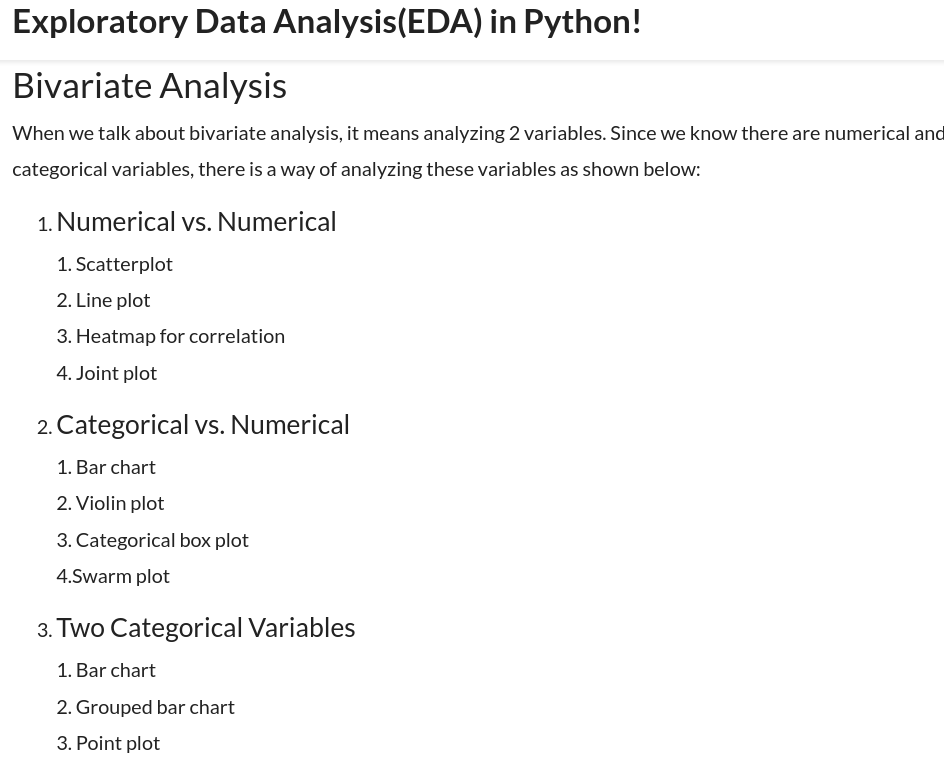

In [ ]:
def highcorr_features(df,target,threshold):
  """
     this function gives the high correlated features  based on the given threshold values.

  """
  from scipy.stats import kendalltau
  cor_mat = df.corr(method="kendall")
  # compute the correlation matrix based on the given dataframe

  corr_high = cor_mat[abs(cor_mat["TARGET"])>threshold]
  # pick the columns having more correlation than threshold value.

  corr = corr_high.sort_values(by="TARGET",ascending=False) 
  # sort the dataframe based on the target column.

  column_names = corr.T.columns
  print("the {0} columns having more correlation to the {1} feature.".format(len(column_names),target))

  return column_names


In [ ]:
def ros(df,target):
  """
  # https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

  this function is used to perform the oversampling. 
  """

  from imblearn.over_sampling import SMOTE
  from collections import Counter
  counter = Counter(df[target][:])
  print("before sampling : ",counter)
  smt=SMOTE()
  #oversampling the training dataset using smote
  x,y = smt.fit_resample(df.drop(target,axis=1),df[target])

  counter = Counter(y)
  print("after smote",counter)
  #data = np.r_[x,y]
  #X_combined = np.r_[X_train, X_test]
  data = pd.concat([x,y],axis=1)
  print(type(data))
  print("after applying the SMOTE dataframe shape is : ",data.shape)
  return data


In [ ]:
#high dimension visualizations using tsne
def tsnevisualizations(df,target):
  from sklearn.manifold import TSNE
  perplexi = [50,100,150,200]
  plt.figure(figsize=(10,10))

  for i in range(len(perplexi)):
    #plt.subplot(2,2,i+1)
    tsne = TSNE(n_components=2,perplexity=perplexi[i],random_state=0)
    tsne=tsne.fit_transform(df.drop([target],axis=1))
    dim_1 = tsne[:,0]
    dim_2 = tsne[:,1]

    tdf = pd.DataFrame({"dim_1":tsne[:,0],"dim_2":tsne[:,1],"target":df[target]})

    sns.FacetGrid(tdf,hue="target",height=5).map(plt.scatter,"dim_1","dim_2").add_legend()
    plt.show()


In [ ]:
# load the datasets by using pandas.
dataframe_train = pd.read_csv("train.csv")
dataframe_test = pd.read_csv("test.csv")

In [ ]:
# analyze the dataset
dataset_analysis(dataframe_train)
#dataset_analysis(dataframe_test)

This dataset having 76020 rows and 371 columns.
dataset have 260 integer type & 111 float type & 0 object type
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None
--------------------------------------------------


### observation:
1.this dataset contain 371 features and "TARGET" feature is the dependent variable.

2.it contains 76020 datapoints.

3.there is no categorical features & all are numerical features.

In [ ]:
missingdata_pts(dataframe_train)
missingdata_pts(dataframe_test)

the missing values in the given dataset is 0.
the missing values in the given dataset is 0.


<h4>observation:</h4>
1.there is no missing values in the train & test datasets.

### outliers removal

the no of unique columns in the column : 2


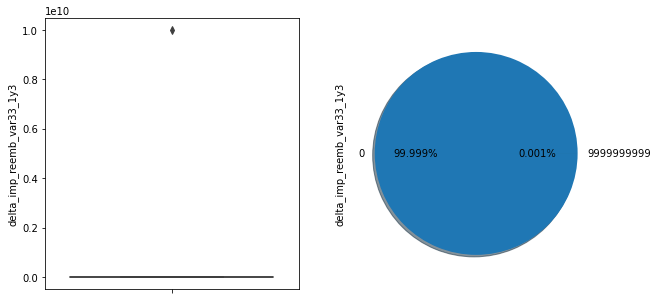

================0-100th percentile================
0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 0
40 percentile value is 0
50 percentile value is 0
60 percentile value is 0
70 percentile value is 0
80 percentile value is 0
90 percentile value is 0
100 percentile value is  9999999999
===============90-100th percentile================
90 percentile value is 0
91 percentile value is 0
92 percentile value is 0
93 percentile value is 0
94 percentile value is 0
95 percentile value is 0
96 percentile value is 0
97 percentile value is 0
98 percentile value is 0
99 percentile value is 0
100 percentile value is  9999999999
===============99-100th percentile ===============
99.0 percentile value is 0
99.1 percentile value is 0
99.2 percentile value is 0
99.3 percentile value is 0
99.4 percentile value is 0
99.5 percentile value is 0
99.6 percentile value is 0
99.7 percentile value is 0
99.8 percentile value is 0
99.9 percentile value is 0
100 pe

In [ ]:
feature_outlier_analysis(dataframe_train,"delta_imp_reemb_var33_1y3")

<h4>observation:</h4>
1.based on the above report this column containing outlier point.

2.99.9 percent of the values are zero.

3.so now we need to drop the point having other than value zero in "delta_imp_reemb_var33_1y3".

4.this type of columns also not useful for our classification

In [ ]:
dataframe_train[dataframe_train["delta_imp_reemb_var33_1y3"]!=0][["TARGET","delta_imp_reemb_var33_1y3"]] # only one point in the dataset 

TARGET  delta_imp_reemb_var33_1y3
24894       0                 9999999999

In [ ]:
# remove that outlier point.
dataframe_train = dataframe_train[dataframe_train["delta_imp_reemb_var33_1y3"]==0]
dataframe_train.shape

(76019, 371)

the no of unique columns in the column : 2


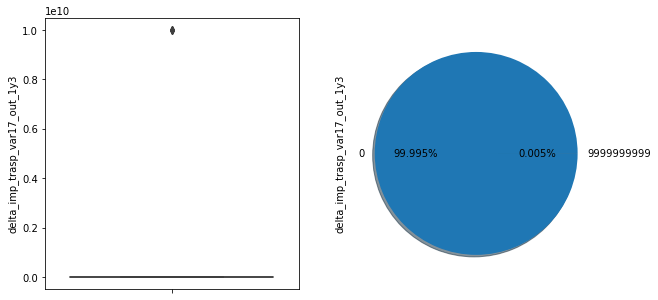

================0-100th percentile================
0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 0
40 percentile value is 0
50 percentile value is 0
60 percentile value is 0
70 percentile value is 0
80 percentile value is 0
90 percentile value is 0
100 percentile value is  9999999999
===============90-100th percentile================
90 percentile value is 0
91 percentile value is 0
92 percentile value is 0
93 percentile value is 0
94 percentile value is 0
95 percentile value is 0
96 percentile value is 0
97 percentile value is 0
98 percentile value is 0
99 percentile value is 0
100 percentile value is  9999999999
===============99-100th percentile ===============
99.0 percentile value is 0
99.1 percentile value is 0
99.2 percentile value is 0
99.3 percentile value is 0
99.4 percentile value is 0
99.5 percentile value is 0
99.6 percentile value is 0
99.7 percentile value is 0
99.8 percentile value is 0
99.9 percentile value is 0
100 pe

In [ ]:
# delta_imp_trasp_var17_out_1y3
feature_outlier_analysis(dataframe_train,"delta_imp_trasp_var17_out_1y3")

<h4>observations:</h4>
1.In this column 4 values having 999999999 value remaining all are zero.

2.from the above analysis these 4 points are considered as outliers.

3.drop those 4 points it is not effect out classification

In [ ]:
# from this analysis there is outlier points exist in this column.
# all of the values are zero except four values . 
print(dataframe_train[dataframe_train["delta_imp_trasp_var17_out_1y3"]!=0][["TARGET","delta_imp_trasp_var17_out_1y3"]])
# remove those points 
dataframe_train = dataframe_train[dataframe_train["delta_imp_trasp_var17_out_1y3"]==0] 
# keep the values having the zero in the dataset.
print("after discarding the outlier points : ",dataframe_train.shape)

       TARGET  delta_imp_trasp_var17_out_1y3
23627       0                     9999999999
36387       0                     9999999999
47376       0                     9999999999
68116       0                     9999999999
after discarding the outlier points :  (76015, 371)


the no of unique columns in the column : 2


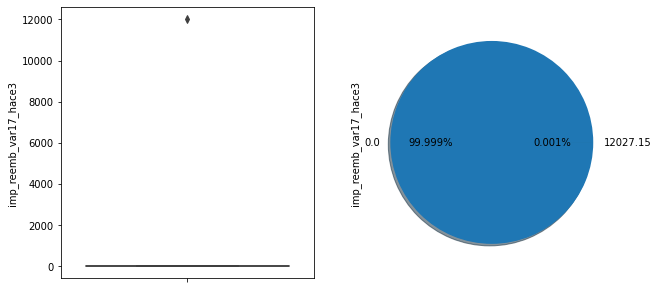

================0-100th percentile================
0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 0.0
70 percentile value is 0.0
80 percentile value is 0.0
90 percentile value is 0.0
100 percentile value is  12027.15
===============90-100th percentile================
90 percentile value is 0.0
91 percentile value is 0.0
92 percentile value is 0.0
93 percentile value is 0.0
94 percentile value is 0.0
95 percentile value is 0.0
96 percentile value is 0.0
97 percentile value is 0.0
98 percentile value is 0.0
99 percentile value is 0.0
100 percentile value is  12027.15
===============99-100th percentile ===============
99.0 percentile value is 0.0
99.1 percentile value is 0.0
99.2 percentile value is 0.0
99.3 percentile value is 0.0
99.4 percentile value is 0.0
99.5 percentile value is 0.0
99.6 percentile value is 0.0
99.7 percentile value is 0.0
99.8 per

In [ ]:
# perform outlier analysis
feature_outlier_analysis(dataframe_train,"imp_reemb_var17_hace3")

<h4>observation:</h4>
1.from the above analysis more values are having zero.

2.only one point having their value as 12027.15 

3.so we consider that point as an outlier.

In [ ]:

print(dataframe_train[dataframe_train["imp_reemb_var17_hace3"]!=0][["TARGET","imp_reemb_var17_hace3"]]) 
# remove those points 
dataframe_train = dataframe_train[dataframe_train["imp_reemb_var17_hace3"]==0] 
# keep the values having the zero in the dataset.
print("after discarding the outlier points : ",dataframe_train.shape)

       TARGET  imp_reemb_var17_hace3
72995       0               12027.15
after discarding the outlier points :  (76014, 371)


the no of unique columns in the column : 2


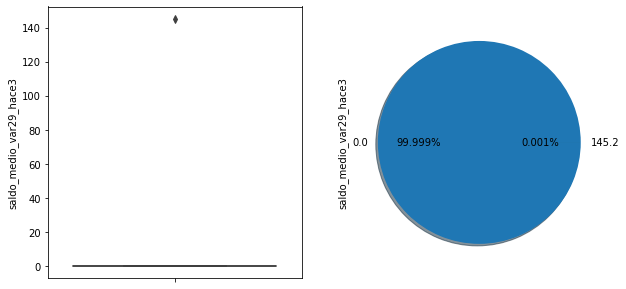

================0-100th percentile================
0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 0.0
70 percentile value is 0.0
80 percentile value is 0.0
90 percentile value is 0.0
100 percentile value is  145.2
===============90-100th percentile================
90 percentile value is 0.0
91 percentile value is 0.0
92 percentile value is 0.0
93 percentile value is 0.0
94 percentile value is 0.0
95 percentile value is 0.0
96 percentile value is 0.0
97 percentile value is 0.0
98 percentile value is 0.0
99 percentile value is 0.0
100 percentile value is  145.2
===============99-100th percentile ===============
99.0 percentile value is 0.0
99.1 percentile value is 0.0
99.2 percentile value is 0.0
99.3 percentile value is 0.0
99.4 percentile value is 0.0
99.5 percentile value is 0.0
99.6 percentile value is 0.0
99.7 percentile value is 0.0
99.8 percentil

In [ ]:
# perform outlier analysis  on "imp_reemb_var33_ult1"
feature_outlier_analysis(dataframe_train,"saldo_medio_var29_hace3")

<h4>observation</h4>
1.from the above analysis only one point having value 145.2 that can be considered as outlier point in that column

2.remaining all points having value as zero.

3.so we need to remove this point.

In [ ]:
print(dataframe_train[dataframe_train["saldo_medio_var29_hace3"]!=0][["TARGET","saldo_medio_var29_hace3"]]) 
# remove those points 
dataframe_train = dataframe_train[dataframe_train["saldo_medio_var29_hace3"]==0] 
# keep the values having the zero in the dataset.
print("after discarding the outlier points : ",dataframe_train.shape)

       TARGET  saldo_medio_var29_hace3
38786       0                    145.2
after discarding the outlier points :  (76013, 371)


the no of unique columns in the column : 9


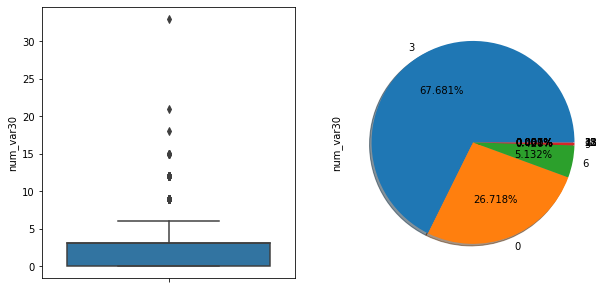

================0-100th percentile================
0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 3
40 percentile value is 3
50 percentile value is 3
60 percentile value is 3
70 percentile value is 3
80 percentile value is 3
90 percentile value is 3
100 percentile value is  33
===============90-100th percentile================
90 percentile value is 3
91 percentile value is 3
92 percentile value is 3
93 percentile value is 3
94 percentile value is 3
95 percentile value is 6
96 percentile value is 6
97 percentile value is 6
98 percentile value is 6
99 percentile value is 6
100 percentile value is  33
===============99-100th percentile ===============
99.0 percentile value is 6
99.1 percentile value is 6
99.2 percentile value is 6
99.3 percentile value is 6
99.4 percentile value is 6
99.5 percentile value is 6
99.6 percentile value is 9
99.7 percentile value is 9
99.8 percentile value is 9
99.9 percentile value is 9
100 percentile value i

In [ ]:
feature_outlier_analysis(dataframe_train,"num_var30")

<h4>observation:</h4>

1.from the above analysis there is some outliers are occured 

2.untill the values having 15 is looking good but remaining 3 values having only one point each other so I considered those are outliers and remove those points.

In [ ]:

print(dataframe_train[dataframe_train["num_var30"]>15][["TARGET","num_var30"]]) 
# remove those points greater than 15 value.
dataframe_train = dataframe_train[dataframe_train["num_var30"]<=15] 
# keep the values having the zero in the dataset.
print("after discarding the outlier points : ",dataframe_train.shape)

       TARGET  num_var30
18276       0         18
34838       0         33
75373       0         21
after discarding the outlier points :  (76010, 371)


the no of unique columns in the column : 6


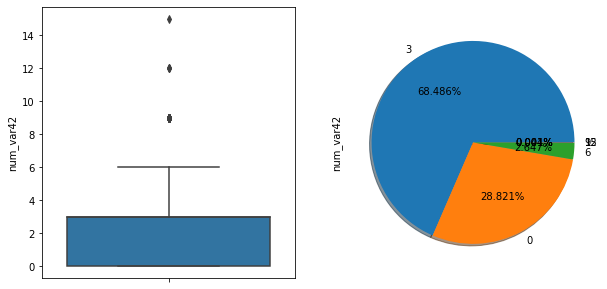

================0-100th percentile================
0 percentile value is 0
10 percentile value is 0
20 percentile value is 0
30 percentile value is 3
40 percentile value is 3
50 percentile value is 3
60 percentile value is 3
70 percentile value is 3
80 percentile value is 3
90 percentile value is 3
100 percentile value is  15
===============90-100th percentile================
90 percentile value is 3
91 percentile value is 3
92 percentile value is 3
93 percentile value is 3
94 percentile value is 3
95 percentile value is 3
96 percentile value is 3
97 percentile value is 3
98 percentile value is 6
99 percentile value is 6
100 percentile value is  15
===============99-100th percentile ===============
99.0 percentile value is 6
99.1 percentile value is 6
99.2 percentile value is 6
99.3 percentile value is 6
99.4 percentile value is 6
99.5 percentile value is 6
99.6 percentile value is 6
99.7 percentile value is 6
99.8 percentile value is 6
99.9 percentile value is 6
100 percentile value i

In [ ]:
feature_outlier_analysis(dataframe_train,"num_var42")

<h4>observation:</h4>
1.from the above analysis only 100% value is 15.

2.here I will consider 12,15 are outlier points.

3.drop those points.

## constant & quasi constant & duplicated features removal

In [ ]:
cons = constant_features(dataframe_train)
dataframe_train = dataframe_train.drop(cons,axis=1)
print("shape of the tarin data after removing the constant features :",dataframe_train.shape)

quasicons = quasiconstant_features(dataframe_train)
dataframe_train = dataframe_train.drop(quasicons,axis=1)
print("the shape of the dataframe after removing the quasiconstant features :",dataframe_train.shape)

45 of constant features in the given dataframe
shape of the tarin data after removing the constant features : (76010, 326)
The no of quasiconstant features in the given dataframe:60
the shape of the dataframe after removing the quasiconstant features : (76010, 266)


In [ ]:
dataframe_train = duplicate_feature_removal(dataframe_train)
print("the shape of the dataframe after removing the duplicate features : ",dataframe_train.shape)

The no of duplicated columns are removed having same values :  15
the shape of the dataframe after removing the duplicate features :  (76010, 251)


## columns analysis

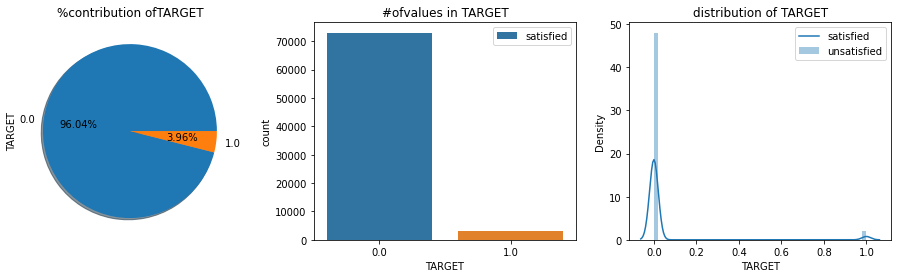

In [ ]:
column_analysis(dataframe_train,"TARGET")

<h4>observations:</h4>

1.from the above analysis we got the "TARGET" column having 2 values.

2.we need to build the model to predict the "TARGET" column based on the above plots it is imbalanced dataset 

3.need to balance the dataset using oversampling/upsampling techniques.

4.both having the normal distribution .

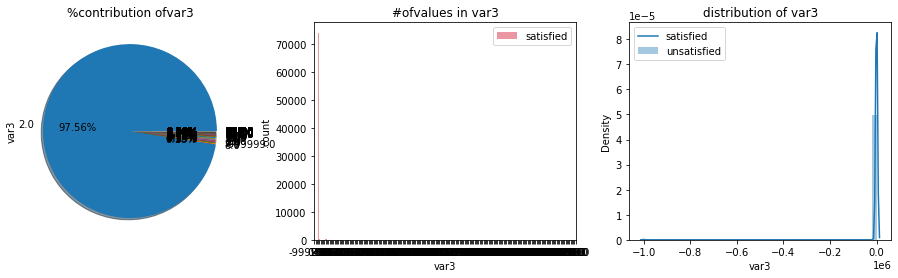

In [ ]:
column_analysis(dataframe_train,"var3")

<h4>observation:</h4>

1.this analysis not gives the proper information so I can perform feature outlier analysis to get more intutiion.

2.if there is any outlier happened replace with median or remove those outliers 

the no of unique columns in the column : 208


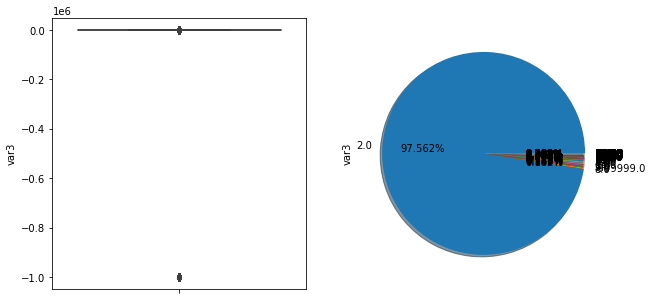

================0-100th percentile================
0 percentile value is -999999.0
10 percentile value is 2.0
20 percentile value is 2.0
30 percentile value is 2.0
40 percentile value is 2.0
50 percentile value is 2.0
60 percentile value is 2.0
70 percentile value is 2.0
80 percentile value is 2.0
90 percentile value is 2.0
100 percentile value is  238.0
===============90-100th percentile================
90 percentile value is 2.0
91 percentile value is 2.0
92 percentile value is 2.0
93 percentile value is 2.0
94 percentile value is 2.0
95 percentile value is 2.0
96 percentile value is 2.0
97 percentile value is 2.0
98 percentile value is 3.0
99 percentile value is 11.0
100 percentile value is  238.0
===============99-100th percentile ===============
99.0 percentile value is 11.0
99.1 percentile value is 12.0
99.2 percentile value is 13.0
99.3 percentile value is 14.0
99.4 percentile value is 16.0
99.5 percentile value is 30.0
99.6 percentile value is 60.0
99.7 percentile value is 106.

In [ ]:
dataframe_train["var3"].value_counts()
feature_outlier_analysis(dataframe_train,"var3") 

<h4>observation:</h4>
1.from this analysis this column having -999999 value and I was considered it is an outlier value .

2.so I need to replacing this value because more points having this value.
we can drop these points may effects our classification


the no of unique columns in the column : 207


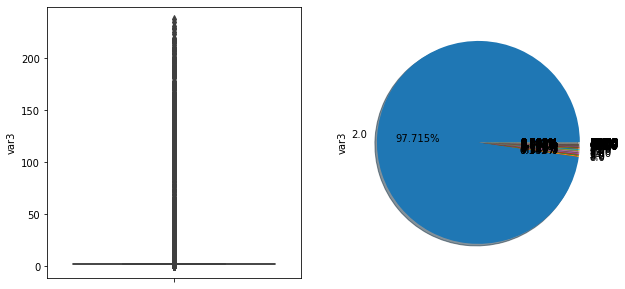

================0-100th percentile================
0 percentile value is 0.0
10 percentile value is 2.0
20 percentile value is 2.0
30 percentile value is 2.0
40 percentile value is 2.0
50 percentile value is 2.0
60 percentile value is 2.0
70 percentile value is 2.0
80 percentile value is 2.0
90 percentile value is 2.0
100 percentile value is  238.0
===============90-100th percentile================
90 percentile value is 2.0
91 percentile value is 2.0
92 percentile value is 2.0
93 percentile value is 2.0
94 percentile value is 2.0
95 percentile value is 2.0
96 percentile value is 2.0
97 percentile value is 2.0
98 percentile value is 3.0
99 percentile value is 11.0
100 percentile value is  238.0
===============99-100th percentile ===============
99.0 percentile value is 11.0
99.1 percentile value is 12.0
99.2 percentile value is 13.0
99.3 percentile value is 14.0
99.4 percentile value is 16.0
99.5 percentile value is 30.0
99.6 percentile value is 60.0
99.7 percentile value is 106.0
99.8

In [ ]:
# replacing -999999 value with median value 
replaced_value = dataframe_train["var3"].median()
dataframe_train["var3"] = np.where(dataframe_train["var3"]==-999999.0,replaced_value,dataframe_train["var3"]) # replace with -1.
feature_outlier_analysis(dataframe_train,"var3")

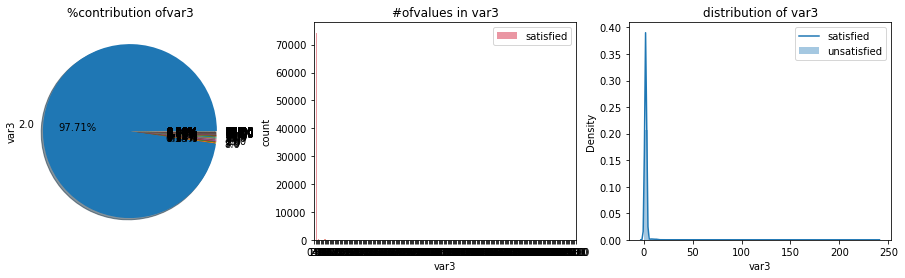

In [ ]:
column_analysis(dataframe_train,"var3")

<h4>observation</h4>
1.most of the points having the value 2

2.distribution is skewed

3.perform univariate_analysis with target column.

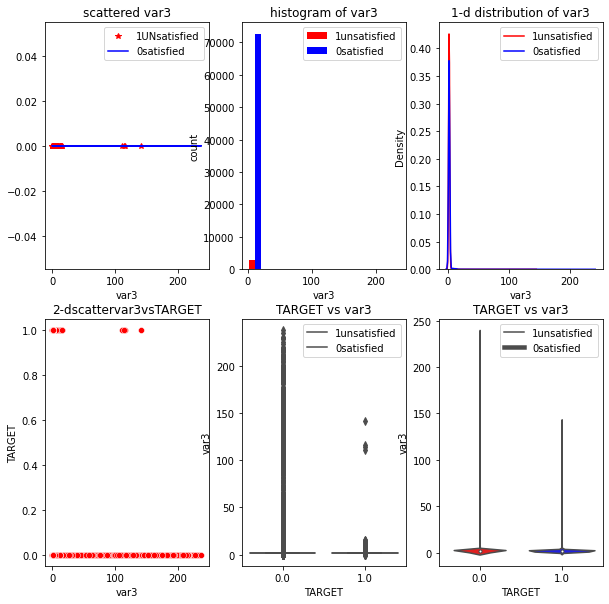

In [ ]:

univariate_analysis(dataframe_train,"TARGET","var3")

<h4>observation:</h4>
1.from the above analysis most of the unsatisfied customer var3 value is 2 only few of the points having other values.

2.satisfied customers also having same format but compared to the unsatisfied satisfied having more points with values other than 2.

3.we can't clssify the customers based on only this variable

# univariate analysis with target

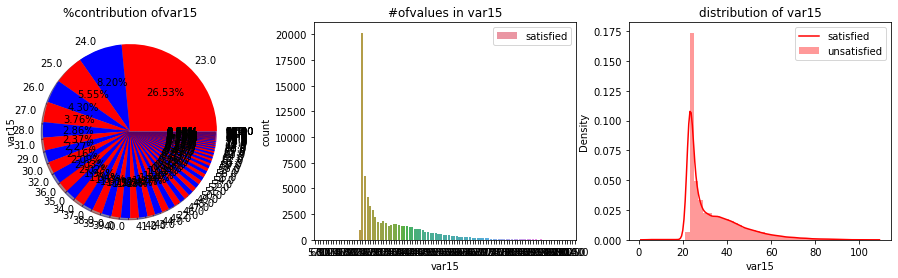

In [ ]:
column_analysis(dataframe_train,"var15")

<h4>observations:</h4>

1.from this analysis 20,000 points having the var15 value is 23.

2.distribution of var15 is right skewed.

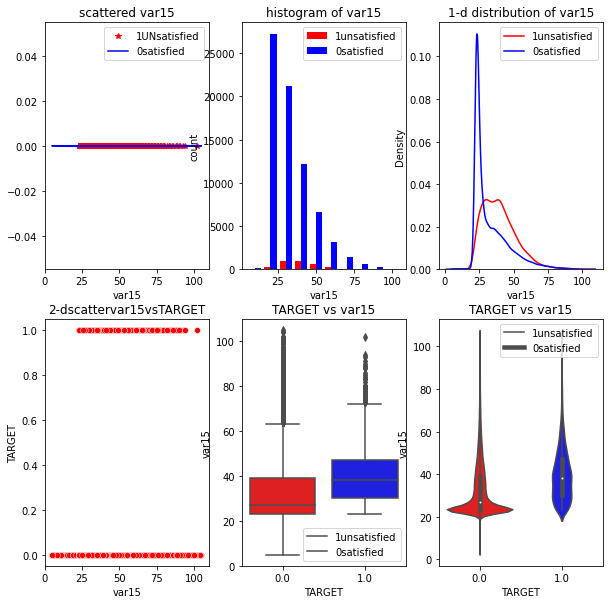

In [ ]:
univariate_analysis(dataframe_train,"TARGET","var15")

<h4>observation:</h4>

1. var15 gives atleast some sense observe there is no unsatisfied customer below the age 23-25(approximately).
2. satisfied customers 75% of the values having 40  and unsatisfied customers around 65% value is 40 .
3.this column is useful to our classification 

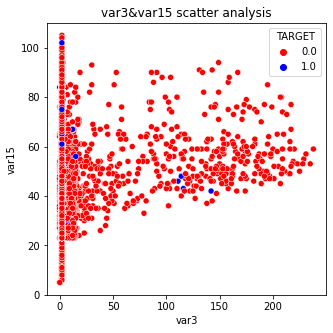

<Figure size 360x360 with 0 Axes>

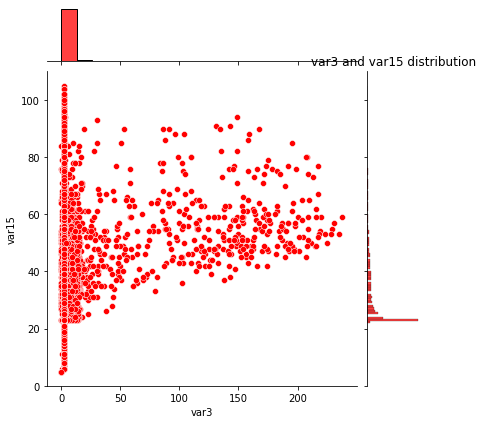

<Figure size 360x360 with 0 Axes>

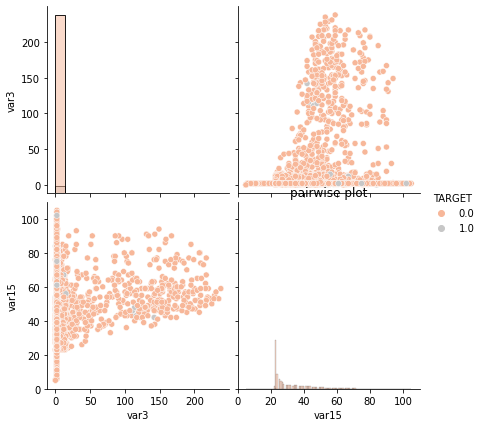

In [ ]:
bivariate_analysis(dataframe_train,"TARGET","var3","var15")

<h4> observation</h4>

1.this analysis not gives much more information& only satisfied customers data is dominated the unsatisfied customers.

In [ ]:
# perform analysis with different variables and observe your interpretation.


## correlated features with target 

In [ ]:
more_corr=highcorr_features(dataframe_train,"TARGET",0.01) # keep those high correlated features.

the 115 columns having more correlation to the TARGET feature.


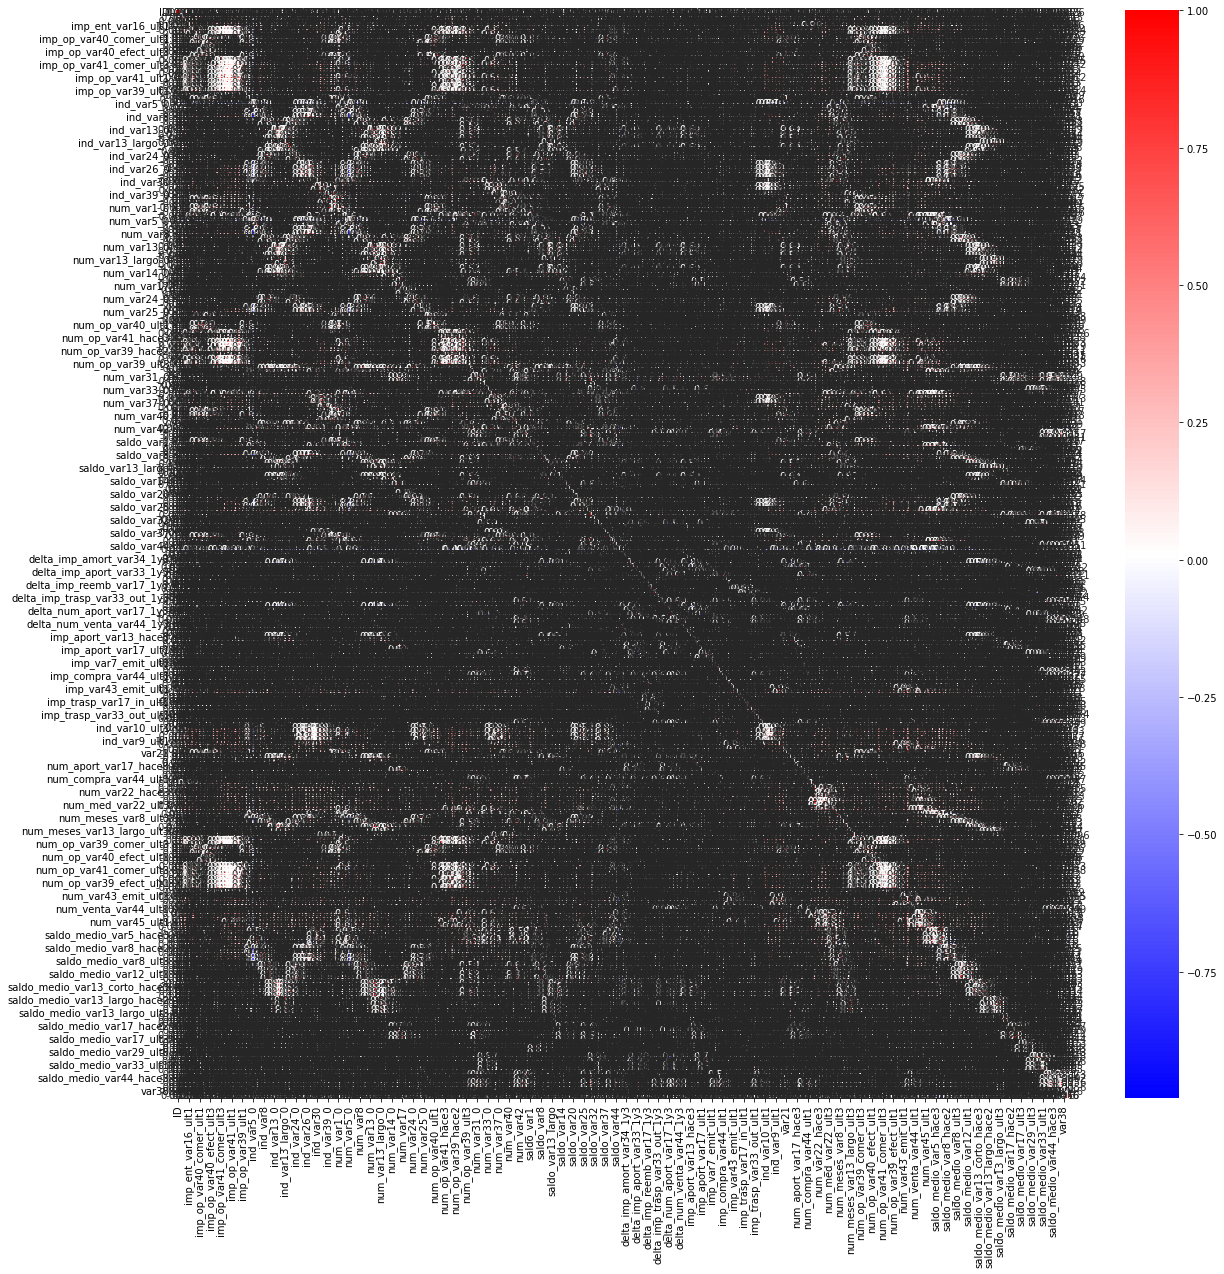

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(dataframe_train.corr(method="kendall"), cmap='bwr', annot=True)     # annot = True: to display the correlation value in the graph

In [ ]:
heat_mat= dataframe_train.corr(method="kendall")

In [ ]:
dataframe_train = dataframe_train[more_corr] # got more correlated columns
dataframe_train.shape

(76010, 115)

In [ ]:
dataframe_train.head(3)

TARGET  var15  var36  ind_var8_0  num_var8_0  num_meses_var8_ult3  \
0     0.0   23.0   99.0         0.0         0.0                  0.0   
1     0.0   34.0    3.0         0.0         0.0                  0.0   
2     0.0   23.0   99.0         0.0         0.0                  0.0   

   imp_op_var40_efect_ult1  num_op_var40_efect_ult1  imp_op_var40_efect_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   num_op_var40_efect_ult3  num_var8  ind_var8  saldo_var8  \
0                      0.0       0.0       0.0         0.0   
1                      0.0       0.0       0.0         0.0   
2                      0.0       0.0       0.0         0.0   

   saldo_medio_var8_ult1  saldo_medio_var8_ult3  ind_var26_cte  ind_var25_cte  \
0                    0.0                    0.0            0.0            0.0   
1                    0.0                    0.0            0.0            0.0   
2                    0.0                    0.0            0.0            0.0   

   delta_num_aport_var13_1y3  delta_imp_aport_var13_1y3  \
0                        0.0                        0.0   
1                       -1.0                       -1.0   
2                        0.0                        0.0   

   saldo_medio_var8_hace2  ind_var25_0  num_var25_0  saldo_var25  ind_var26_0  \
0                     0.0          0.0          0.0          0.0          0.0   
1                     0.0          0.0          0.0          0.0          0.0   
2                     0.0          0.0          0.0          0.0          0.0   

   num_var26_0  saldo_var26  imp_op_var41_efect_ult3  imp_op_var39_efect_ult3  \
0          0.0          0.0                      0.0                      0.0   
1          0.0          0.0                      0.0                      0.0   
2          0.0          0.0                      0.0                      0.0   

   saldo_medio_var8_hace3  imp_op_var39_efect_ult1  imp_op_var41_efect_ult1  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   

   num_op_var41_efect_ult3  num_op_var39_efect_ult3  num_op_var39_efect_ult1  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   num_op_var41_efect_ult1  ind_var10_ult1  saldo_var20  num_var20  \
0                      0.0             0.0          0.0        0.0   
1                      0.0             0.0          0.0        0.0   
2                      0.0             0.0          0.0        0.0   

   num_trasp_var11_ult1  num_var20_0  saldo_medio_var13_largo_hace3  var3  \
0                   0.0          0.0                            0.0   2.0   
1                   0.0          0.0                            0.0   2.0   
2                   0.0          0.0                            0.0   2.0   

   saldo_medio_var13_largo_hace2  saldo_medio_var13_largo_ult3  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   

   saldo_medio_var13_largo_ult1  num_var45_ult3  num_meses_var13_largo_ult3  \
0                           0.0             0.0                         0.0   
1                           0.0             0.0                         0.0   
2                           0.0             0.0                         0.0   

   num_med_var45_ult3  saldo_var13_largo  num_var13_largo  num_var13_largo_0  \
0                 0.0                0.0  

In [ ]:
dataframe_train1=dataframe_train

## SMOTE

In [ ]:
dataframe_train = ros(dataframe_train,"TARGET")

before sampling :  Counter({0.0: 73002, 1.0: 3008})
after smote Counter({0.0: 73002, 1.0: 73002})
<class 'pandas.core.frame.DataFrame'>
after applying the SMOTE dataframe shape is :  (146004, 115)


## Tsne visualization:

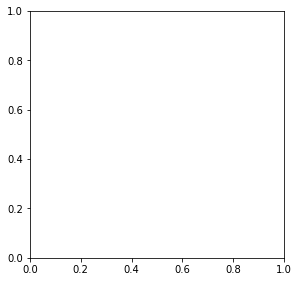

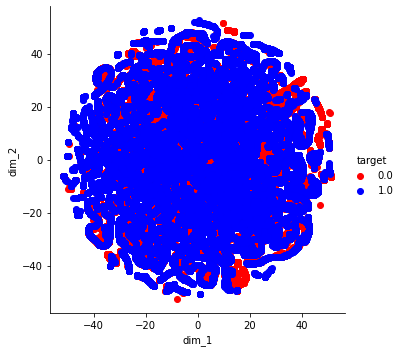

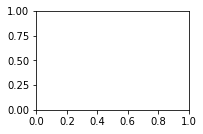

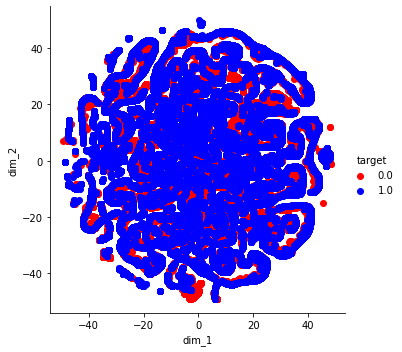

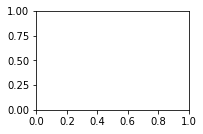

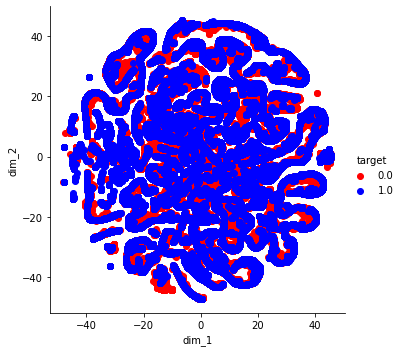

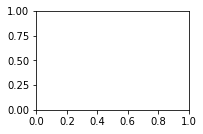

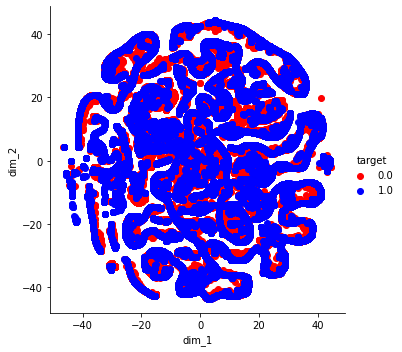

In [ ]:
tsnevisualizations(dataframe_train,"TARGET")

<h4>observation:</h4>

1. there is so much overlapping between satisfied and unsatisfied customers.

2. the data is not organized well .



## feature importance

In [ ]:
# feature importance
# https://vitalflux.com/feature-importance-random-forest-classifier-python/
# https://predictivehacks.com/feature-importance-in-python/

In [ ]:
X = dataframe_train.drop(["TARGET"],axis=1)
Y = dataframe_train["TARGET"]

In [ ]:
model=RandomForestClassifier()
 
model.fit(X,Y)
# create dataframe with the features and its corresponding feature importance values. 
feature_importances=pd.DataFrame({'features':X.columns,'feature_importance':model.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False,inplace=True)

In [ ]:
feature_importances.head(80)

features  feature_importance
0                           var15            0.184029
98                          var38            0.102968
109           num_meses_var5_ult3            0.061294
100                      num_var4            0.043333
44                 num_var45_ult3            0.038074
99                      num_var35            0.034820
110                      ind_var5            0.033442
1                           var36            0.030752
111                     num_var42            0.028999
113                     ind_var30            0.028484
112                     num_var30            0.027938
101        saldo_medio_var5_hace3            0.026125
108                      num_var5            0.024467
107                   saldo_var30            0.020861
105                   saldo_var42            0.020838
102         saldo_medio_var5_ult3            0.019554
46             num_med_var45_ult3            0.017383
103         saldo_medio_var5_ult1            0.015434
59                num_var45_hace2            0.015163
54                 num_var45_ult1            0.014108
104        saldo_medio_var5_hace2            0.014051
106                    saldo_var5            0.013882
64                    num_var39_0            0.013877
89                    ind_var39_0            0.013164
81                    ind_var41_0            0.011884
67                    num_var41_0            0.011714
34                 ind_var10_ult1            0.010278
30        num_op_var41_efect_ult3            0.008812
57           ind_var43_recib_ult1            0.007529
31        num_op_var39_efect_ult3            0.006989
32        num_op_var39_efect_ult1            0.006605
33        num_op_var41_efect_ult1            0.006309
25        imp_op_var41_efect_ult3            0.005424
55           num_var43_recib_ult1            0.005241
26        imp_op_var39_efect_ult3            0.005148
63                     num_var5_0            0.004393
97                    num_var30_0            0.004088
56           imp_trans_var37_ult1            0.004035
29        imp_op_var41_efect_ult1            0.003905
28        imp_op_var39_efect_ult1            0.003473
73                     ind_var5_0            0.003209
91                    ind_var12_0            0.002968
2                      ind_var8_0            0.002951
3                      num_var8_0            0.002837
62                    num_var42_0            0.002797
40                           var3            0.001887
95                      num_var13            0.001819
90                    num_var12_0            0.001609
93                    num_var13_0            0.001550
4             num_meses_var8_ult3            0.001493
92                    saldo_var13            0.001335
13          saldo_medio_var8_ult3            0.001309
12          saldo_medio_var8_ult1            0.001295
11                     saldo_var8            0.001284
96                      ind_var13            0.001106
10                       ind_var8            0.001031
22                    ind_var26_0            0.000954
9                        num_var8            0.000953
84                      ind_var12            0.000877
94                    ind_var13_0            0.000862
18         saldo_medio_var8_hace2            0.000821
21                    saldo_var25            0.000814
83                      num_var12            0.000736
20                    num_var25_0            0.000698
23                    num_var26_0            0.000667
14                  ind_var26_cte            0.000666
19                    ind_var25_0            0.000652
66                    ind_var24_0            0.000644
37           num_trasp_var11_ult1            0.000615
78   saldo_medio_var13_corto_ult3            0.000609
15                  ind_var25_cte            0.000582
68        saldo_medio_var12_hace2            0.000562
24                    saldo_var26            0.000546
75         saldo_medio_var12_

In [ ]:
feature_importances.to_csv("feature_importnace_on_with_high_corr")

In [ ]:
#model1=RandomForestClassifier()
 
#model1.fit(X,Y)
# create dataframe with the features and its corresponding feature importance values. 
#feature_importances1=pd.DataFrame({'features':X.columns,'feature_importance':model1.feature_importances_})
#feature_importances1.sort_values('feature_importance',ascending=False,inplace=True)

In [ ]:
type(model.feature_importances_)

numpy.ndarray

In [ ]:
#feature_importances1.head(80)

In [ ]:
#important_cols=["var15","var38","num_meses_var5_ult3","ind_var30","num_var30","num_var5","num_var45_ult3","num_var4","ind_var5","var36","num_var42","num_var35","saldo_medio_var5_hace3"]
#l2 = ["saldo_medio_var5_ult3","saldo_var5",'num_var45_hace2',"saldo_medio_var5_ult1","saldo_medio_var5_hace2","saldo_var30","num_med_var45_ult3","saldo_var42","ind_var41_0"]
#l3 = ["num_var39_0","num_var41_0","num_var45_ult1","ind_var39_0","ind_var10_ult1","num_op_var41_efect_ult3","num_op_var39_efect_ult3","ind_var43_recib_ult1","num_op_var41_efect_ult1"]
#l4=["num_op_var39_efect_ult1","num_var30_0","imp_op_var41_efect_ult3","num_var43_recib_ult1","imp_trans_var37_ult1","imp_op_var39_efect_ult1","num_var8_0","imp_op_var39_efect_ult3"]
#l5=["num_var5_0"]

<h4>observation</h4>

1. this plot represents the each feature and its corresponding feature importance 

2. untill the feature "num_var24_0" useful and remaining are not useful according to the above plot.

In [ ]:
top_features=feature_importances[feature_importances["feature_importance"]>=3.179678e-04]
# I taken this threshold value based on the plot 
print(" top features data shape :",top_features.shape)
required=[] # creates an empty list to store column names
for i in top_features["features"][:]:
  required.append(i) # append those feature into required list
print("the no of features are selected : ",len(required))
# create new dataframe 

new_X = X[required] #select those required columns from the X dataframe
print("the shape of the new dataframe : ",new_X.shape)
new_X.to_csv("top_features.csv", index=False)
new_X.head(3)

 top features data shape : (85, 2)
the no of features are selected :  85
the shape of the new dataframe :  (146004, 85)


var15     var38  num_meses_var5_ult3  num_var4  num_var45_ult3  num_var35  \
0   23.0  39205.17                  0.0       0.0             0.0        0.0   
1   34.0  49278.03                  1.0       1.0             0.0        3.0   
2   23.0  67333.77                  3.0       1.0             0.0        3.0   

   ind_var5  var36  num_var42  ind_var30  num_var30  saldo_medio_var5_hace3  \
0       0.0   99.0        0.0        0.0        0.0                    0.00   
1       0.0    3.0        0.0        1.0        3.0                   88.89   
2       1.0   99.0        3.0        1.0        3.0                    0.18   

   num_var5  saldo_var30  saldo_var42  saldo_medio_var5_ult3  \
0       0.0          0.0          0.0                   0.00   
1       0.0        300.0          0.0                   0.00   
2       3.0          3.0          3.0                   2.07   

   num_med_var45_ult3  saldo_medio_var5_ult1  num_var45_hace2  num_var45_ult1  \
0                 0.0                    0.0              0.0             0.0   
1                 0.0                    0.0              0.0             0.0   
2                 0.0                    3.0              0.0             0.0   

   saldo_medio_var5_hace2  saldo_var5  num_var39_0  ind_var39_0  ind_var41_0  \
0                     0.0         0.0          3.0          1.0          1.0   
1                     0.0         0.0          3.0          1.0          1.0   
2                     3.0         3.0          3.0          1.0          1.0   

   num_var41_0  ind_var10_ult1  num_op_var41_efect_ult3  ind_var43_recib_ult1  \
0          3.0             0.0                      0.0                   0.0   
1          3.0             0.0                      0.0                   0.0   
2          3.0             0.0                      0.0                   0.0   

   num_op_var39_efect_ult3  num_op_var39_efect_ult1  num_op_var41_efect_ult1  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   imp_op_var41_efect_ult3  num_var43_recib_ult1  imp_op_var39_efect_ult3  \
0                      0.0                   0.0                      0.0   
1                      0.0                   0.0                      0.0   
2                      0.0                   0.0                      0.0   

   num_var5_0  num_var30_0  imp_trans_var37_ult1  imp_op_var41_efect_ult1  \
0         3.0          3.0                   0.0                      0.0   
1         3.0          6.0                   0.0                      0.0   
2         3.0          3.0                   0.0                      0.0   

   imp_op_var39_efect_ult1  ind_var5_0  ind_var12_0  ind_var8_0  num_var8_0  \
0                      0.0         1.0          0.0         0.0         0.0   
1                      0.0         1.0          0.0         0.0         0.0   
2                      0.0         1.0          0.0         0.0         0.0   

   num_var42_0  var3  num_var13  num_var12_0  num_var13_0  \
0          3.0   2.0        0.0          0.0          0.0   
1          3.0   2.0        3.0          0.0          3.0   
2          3.0   2.0        0.0          0.0          0.0   

   num_meses_var8_ult3  saldo_var13  saldo_medio_var8_ult3  \
0                  0.0          0.0                    0.0   
1                  0.0        300.0                    0.0   
2                  0.0          0.0                    0.0   

   saldo_medio_var8_ult1  saldo_var8  ind_var13  ind_var8  ind_var26_0  \
0                    0.0         0.0        0.0       0.0          0.0   
1                    0.0         0.0        1.0       0.0          0.0   
2                    0.0         0.0        0.0       0.0          0.0   

   num_var8  ind_var12  ind_var13_0  saldo_medio_var8_hace2  saldo_var25  \
0       0.0   

Random Forest importance (RF-Imp) determines the usefulness of each feature by measuring the performance difference of the out-of-bag data when noise is added, as proposed by Breiman (2001).

## multivariate analysis

In [ ]:
l=["var15","var38","num_messes_var5_ult3","ind_var30","num_var5","var36","num_var42","num_var35","saldo_media_var5_hace3","saldo_media_var5_ult3","saldo_var5"]

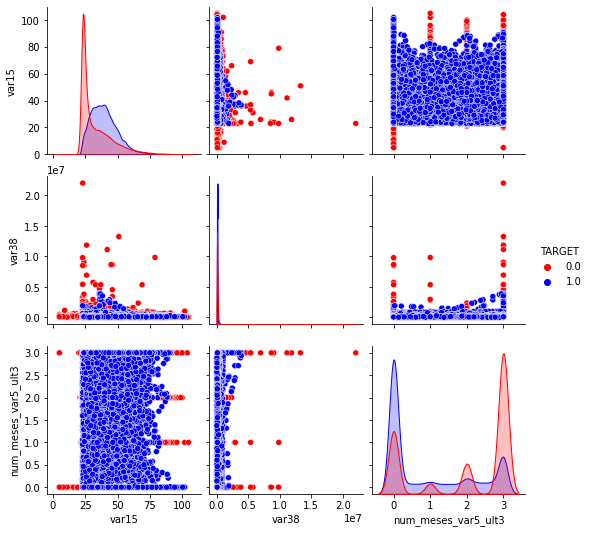

In [ ]:
sns.pairplot(dataframe_train[["var15","var38","num_meses_var5_ult3","TARGET"]],hue="TARGET") # hue ="TARGET",
plt.show()

<h4>observation</h4>

1.if num_meses_var5_ult3 value is zero and var var15 is below 25(approx) considered as satisfied customers. & above that value is considered as unsatisfaction customers.


2.if var15 value is below 25 (approx) and var38 value is zero considered those points are satisfied customers.


3.if var38 value is more than o.5 those customers are considered as satisfied customers.

In [ ]:
# ['saldo_media_var5_hace3', 'num_messes_var5_ult3', 'saldo_media_var5_ult3'] not in index"

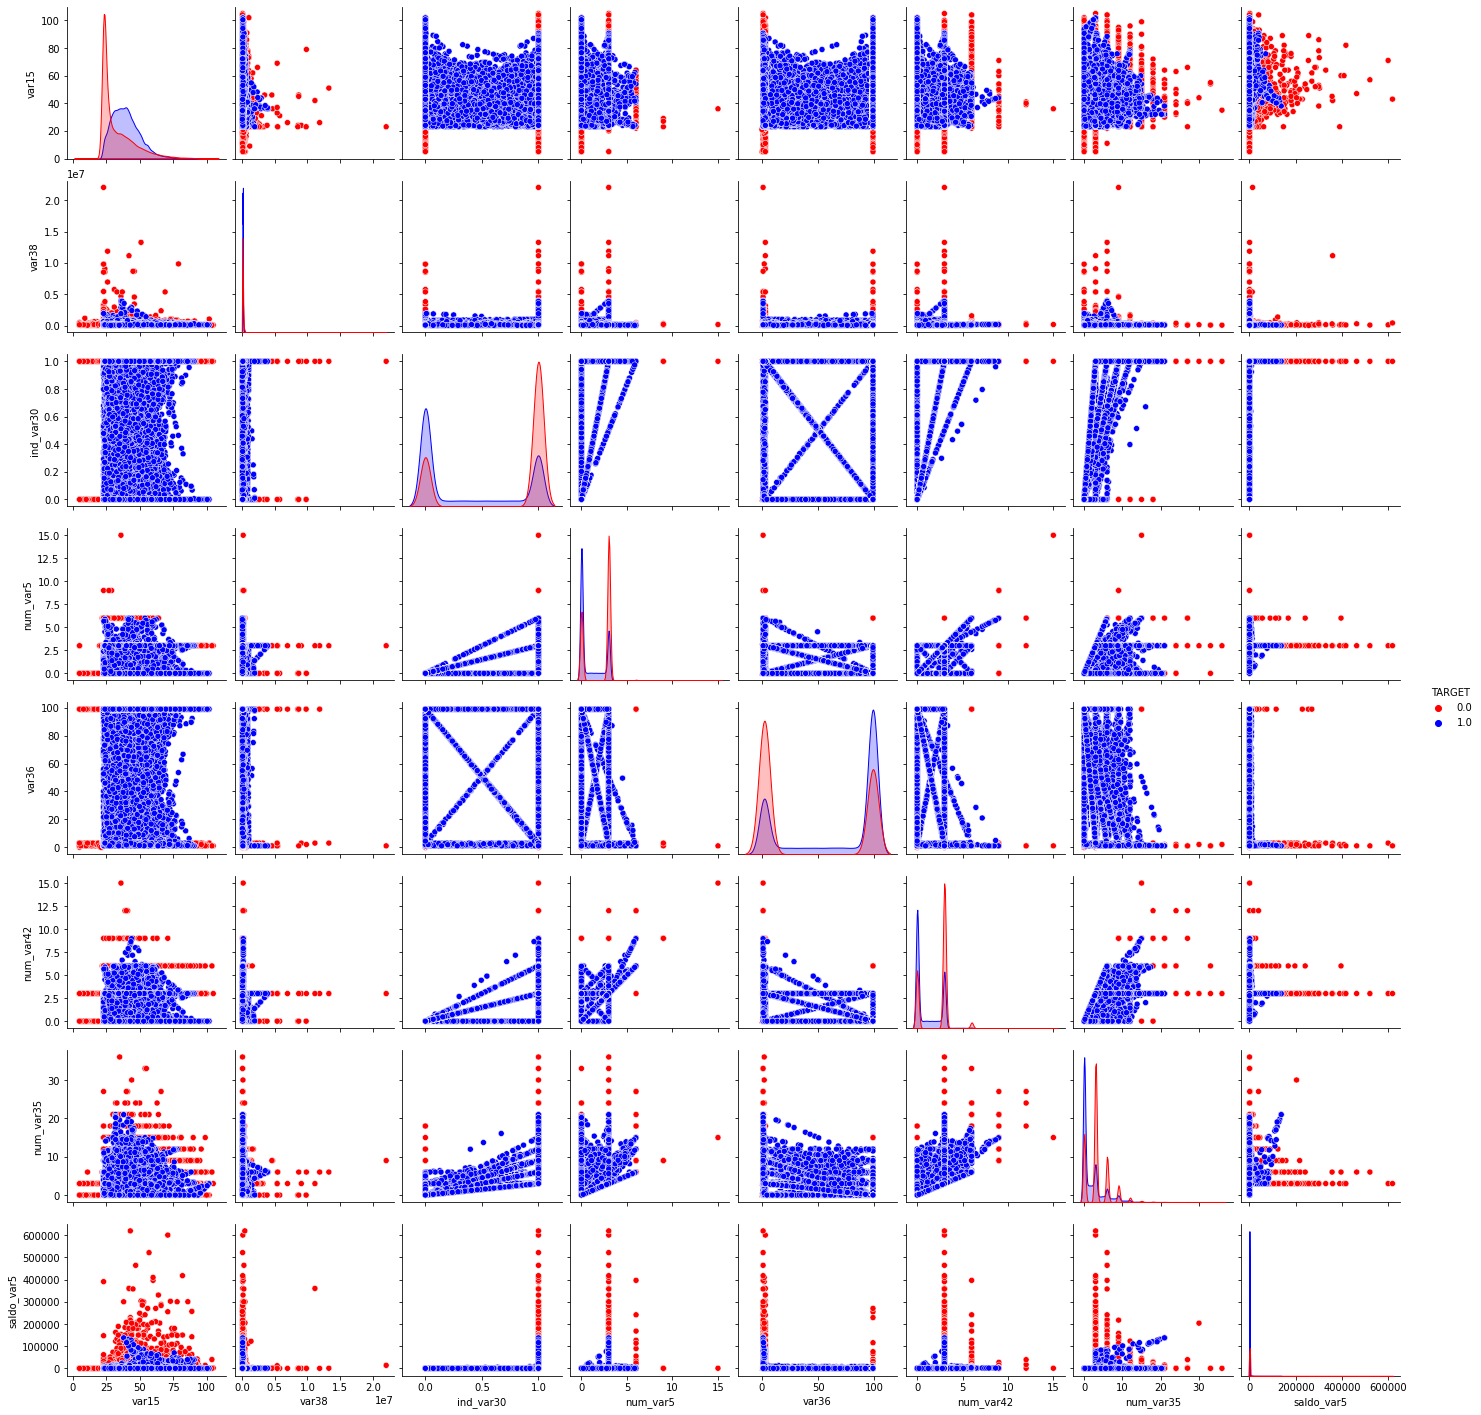

In [ ]:
# perform multivariate analysis on top 10 features coming from the feature importance.
sns.pairplot(dataframe_train[["var15","var38","ind_var30","num_var5","var36","num_var42","num_var35","saldo_var5","TARGET"]],hue="TARGET") # hue ="TARGET",
plt.show()


<h4>observation</h4>

1.if saldo_var5 value is more than 100000(approx) value those customers are satisfied customers.

2.if var15 is below 23(approx) those customers are satisfied customers.

3.if num_var35 value is more than 20 those points are considered as satisfied customers.

4.if saldo_var5 value is 1500000(approx) and ind_var30 value is 1 those points are considered as satisfied customers. if saldo_var5 value is below the 1500000(approx) those points are considered as unsatisfied customers.

5.if saldo_var5 value is below 150000 (approx) and num_var5 value is 0-5 then those points are considered as unsatisfied customers.




## EDA-2

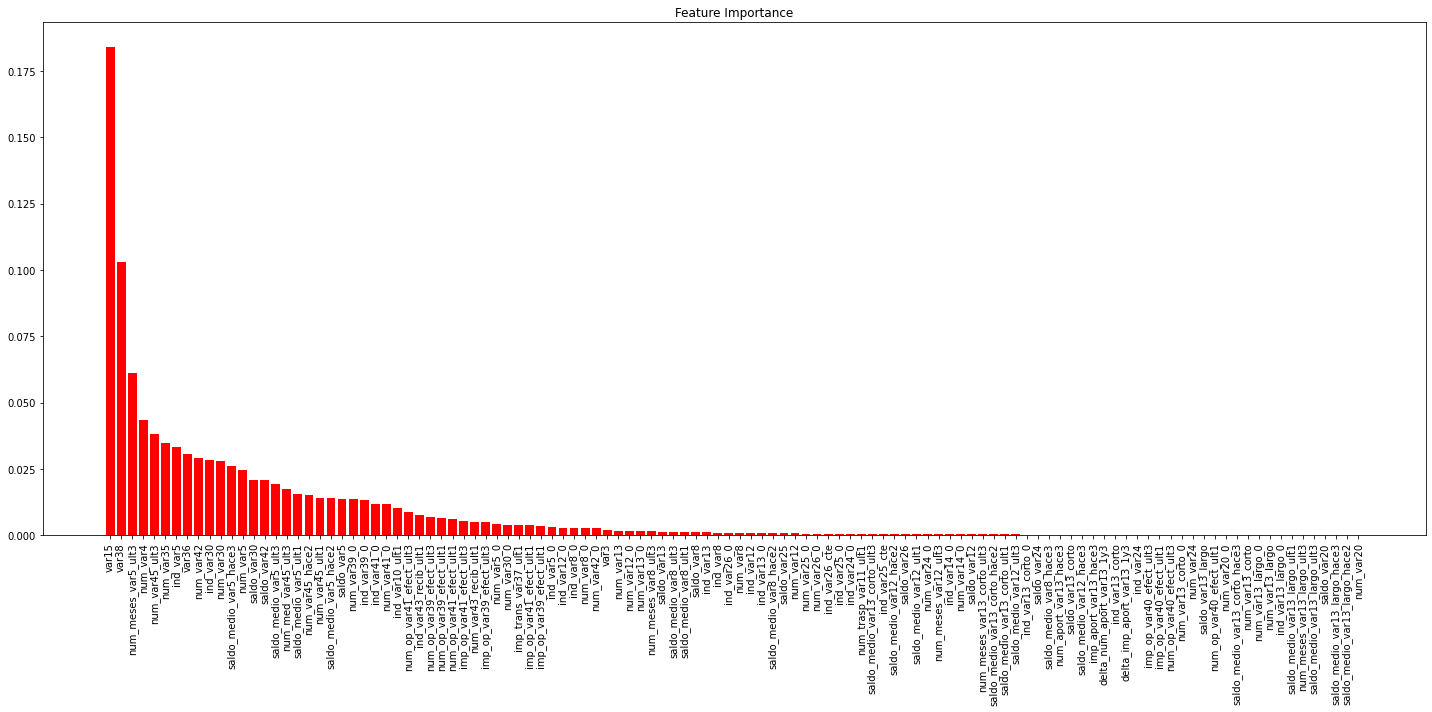

In [ ]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,10))
 
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
feature_importances.head(10)

features  feature_importance
0                  var15            0.184029
98                 var38            0.102968
109  num_meses_var5_ult3            0.061294
100             num_var4            0.043333
44        num_var45_ult3            0.038074
99             num_var35            0.034820
110             ind_var5            0.033442
1                  var36            0.030752
111            num_var42            0.028999
113            ind_var30            0.028484

In [ ]:
def columndistribution_with_target(df,target,col):
  """
    histogramplot:
  """
  plt.figure(figsize=(16,10))
  plt.subplot(1,2,1)
  sns.histplot(x=col,data=df,hue="TARGET")
  plt.xticks(rotation = 0)
  plt.title(col, fontsize = 15, fontweight = 'bold', color = '#bd0b0b')
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.legend(["1unsatisfied","0satisfied"])
  plt.xticks(fontsize = 12, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 12, fontweight = 'bold', color = 'brown')
  plt.tight_layout()
  """
  boxenplot:
  """
  plt.subplot(1,2,2)
  sns.boxenplot(x = target,y = col,  data = df,palette = 'dark')
  plt.xticks(rotation = 0)
  plt.title(f'{col} vs {target}', fontsize = 20, fontweight = 'bold', color = '#bd0b0b')
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.legend(["1unsatisfied","0satisfied"])
  plt.xticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.tight_layout()

  plt.show()


In [ ]:
def bivariate_analysis2(df,target,col1,col2):
  """
     this function takes dataframe and target column & any 2 columns as input.
     gives how those 2 columns are helpful to classification.
  """
  plt.figure(figsize=(5,5))
  sns.scatterplot(x=df[col1],y=df[col2], hue=df[target])
  plt.title("{0}&{1} scatter analysis".format(col1,col2))
  plt.xticks(rotation=0)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.xticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.legend(["1unsatisfied","0satisfied"])
  plt.tight_layout()
  
  #plt.subplot(2,1,2)
  """
   jointplot 
  """
  sns.jointplot(x=df[col1],y=df[col2],hue=df[target])
  plt.title("{0} and {1} distribution".format(col1,col2))
  plt.xticks(rotation=0)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.xticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.legend(["1unsatisfied","0satisfied"])
  plt.tight_layout()
  plt.show()

  """
  heatmap it shows the correlation matrix.
  """
  #plt.subplot(2,2,3)
  plt.figure(figsize=(5,5))
  sns.heatmap(dataframe_train[[col1,col2,target]].corr())
  plt.xticks(rotation=0)
  plt.tight_layout()
  plt.show()

In [ ]:
feature_importances.head(10)

features  feature_importance
0                  var15            0.182137
98                 var38            0.103821
113            ind_var30            0.042231
112            num_var30            0.042041
108             num_var5            0.040355
109  num_meses_var5_ult3            0.039109
44        num_var45_ult3            0.038693
100             num_var4            0.033186
111            num_var42            0.032257
1                  var36            0.029344

In [ ]:
top_picked_features = pd.read_csv("/content/top_features.csv")

In [ ]:
top_picked_features.head(3)

var15     var38  num_meses_var5_ult3  num_var4  num_var45_ult3  num_var35  \
0   23.0  39205.17                  0.0       0.0             0.0        0.0   
1   34.0  49278.03                  1.0       1.0             0.0        3.0   
2   23.0  67333.77                  3.0       1.0             0.0        3.0   

   ind_var5  var36  num_var42  ind_var30  num_var30  saldo_medio_var5_hace3  \
0       0.0   99.0        0.0        0.0        0.0                    0.00   
1       0.0    3.0        0.0        1.0        3.0                   88.89   
2       1.0   99.0        3.0        1.0        3.0                    0.18   

   num_var5  saldo_var30  saldo_var42  saldo_medio_var5_ult3  \
0       0.0          0.0          0.0                   0.00   
1       0.0        300.0          0.0                   0.00   
2       3.0          3.0          3.0                   2.07   

   num_med_var45_ult3  saldo_medio_var5_ult1  num_var45_hace2  num_var45_ult1  \
0                 0.0                    0.0              0.0             0.0   
1                 0.0                    0.0              0.0             0.0   
2                 0.0                    3.0              0.0             0.0   

   saldo_medio_var5_hace2  saldo_var5  num_var39_0  ind_var39_0  ind_var41_0  \
0                     0.0         0.0          3.0          1.0          1.0   
1                     0.0         0.0          3.0          1.0          1.0   
2                     3.0         3.0          3.0          1.0          1.0   

   num_var41_0  ind_var10_ult1  num_op_var41_efect_ult3  ind_var43_recib_ult1  \
0          3.0             0.0                      0.0                   0.0   
1          3.0             0.0                      0.0                   0.0   
2          3.0             0.0                      0.0                   0.0   

   num_op_var39_efect_ult3  num_op_var39_efect_ult1  num_op_var41_efect_ult1  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   imp_op_var41_efect_ult3  num_var43_recib_ult1  imp_op_var39_efect_ult3  \
0                      0.0                   0.0                      0.0   
1                      0.0                   0.0                      0.0   
2                      0.0                   0.0                      0.0   

   num_var5_0  num_var30_0  imp_trans_var37_ult1  imp_op_var41_efect_ult1  \
0         3.0          3.0                   0.0                      0.0   
1         3.0          6.0                   0.0                      0.0   
2         3.0          3.0                   0.0                      0.0   

   imp_op_var39_efect_ult1  ind_var5_0  ind_var12_0  ind_var8_0  num_var8_0  \
0                      0.0         1.0          0.0         0.0         0.0   
1                      0.0         1.0          0.0         0.0         0.0   
2                      0.0         1.0          0.0         0.0         0.0   

   num_var42_0  var3  num_var13  num_var12_0  num_var13_0  \
0          3.0   2.0        0.0          0.0          0.0   
1          3.0   2.0        3.0          0.0          3.0   
2          3.0   2.0        0.0          0.0          0.0   

   num_meses_var8_ult3  saldo_var13  saldo_medio_var8_ult3  \
0                  0.0          0.0                    0.0   
1                  0.0        300.0                    0.0   
2                  0.0          0.0                    0.0   

   saldo_medio_var8_ult1  saldo_var8  ind_var13  ind_var8  ind_var26_0  \
0                    0.0         0.0        0.0       0.0          0.0   
1                    0.0         0.0        1.0       0.0          0.0   
2                    0.0         0.0        0.0       0.0          0.0   

   num_var8  ind_var12  ind_var13_0  saldo_medio_var8_hace2  saldo_var25  \
0       0.0   

In [ ]:
dataframe_train.head(3)

var15  var36  ind_var8_0  num_var8_0  num_meses_var8_ult3  \
0   23.0   99.0         0.0         0.0                  0.0   
1   34.0    3.0         0.0         0.0                  0.0   
2   23.0   99.0         0.0         0.0                  0.0   

   imp_op_var40_efect_ult1  num_op_var40_efect_ult1  imp_op_var40_efect_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   num_op_var40_efect_ult3  num_var8  ind_var8  saldo_var8  \
0                      0.0       0.0       0.0         0.0   
1                      0.0       0.0       0.0         0.0   
2                      0.0       0.0       0.0         0.0   

   saldo_medio_var8_ult1  saldo_medio_var8_ult3  ind_var26_cte  ind_var25_cte  \
0                    0.0                    0.0            0.0            0.0   
1                    0.0                    0.0            0.0            0.0   
2                    0.0                    0.0            0.0            0.0   

   delta_num_aport_var13_1y3  delta_imp_aport_var13_1y3  \
0                        0.0                        0.0   
1                       -1.0                       -1.0   
2                        0.0                        0.0   

   saldo_medio_var8_hace2  ind_var25_0  num_var25_0  saldo_var25  ind_var26_0  \
0                     0.0          0.0          0.0          0.0          0.0   
1                     0.0          0.0          0.0          0.0          0.0   
2                     0.0          0.0          0.0          0.0          0.0   

   num_var26_0  saldo_var26  imp_op_var41_efect_ult3  imp_op_var39_efect_ult3  \
0          0.0          0.0                      0.0                      0.0   
1          0.0          0.0                      0.0                      0.0   
2          0.0          0.0                      0.0                      0.0   

   saldo_medio_var8_hace3  imp_op_var39_efect_ult1  imp_op_var41_efect_ult1  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   

   num_op_var41_efect_ult3  num_op_var39_efect_ult3  num_op_var39_efect_ult1  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   

   num_op_var41_efect_ult1  ind_var10_ult1  saldo_var20  num_var20  \
0                      0.0             0.0          0.0        0.0   
1                      0.0             0.0          0.0        0.0   
2                      0.0             0.0          0.0        0.0   

   num_trasp_var11_ult1  num_var20_0  saldo_medio_var13_largo_hace3  var3  \
0                   0.0          0.0                            0.0   2.0   
1                   0.0          0.0                            0.0   2.0   
2                   0.0          0.0                            0.0   2.0   

   saldo_medio_var13_largo_hace2  saldo_medio_var13_largo_ult3  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   

   saldo_medio_var13_largo_ult1  num_var45_ult3  num_meses_var13_largo_ult3  \
0                           0.0             0.0                         0.0   
1                           0.0             0.0                         0.0   
2                           0.0             0.0                         0.0   

   num_med_var45_ult3  saldo_var13_largo  num_var13_largo  num_var13_largo_0  \
0                 0.0                0.0              0.0                0

In [ ]:
import seaborn as sns

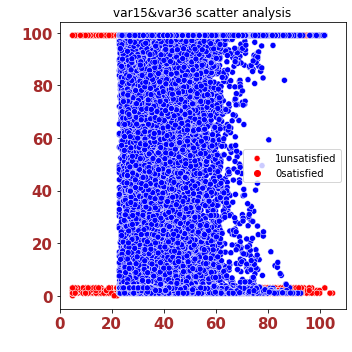

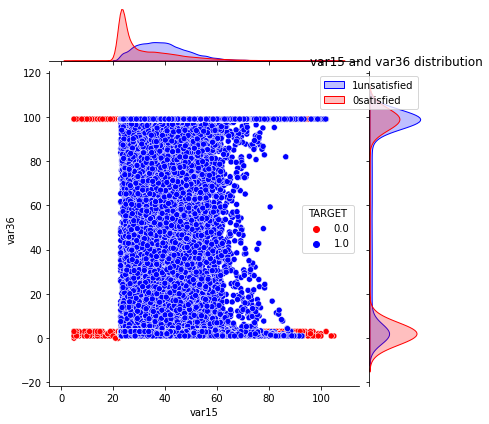

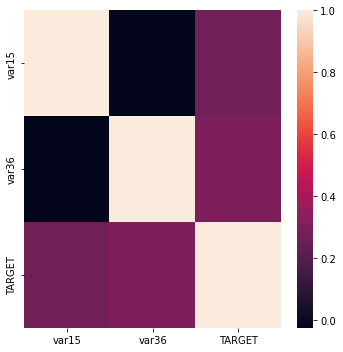

In [ ]:
bivariate_analysis2(dataframe_train,"TARGET","var15","var36")

<pre>
Observation:
1.if the var15 value is below than 23 whatever the var36 value it is considered as the satisfied customers.
2.if the var15 value is between the 23-89(approximately) whatever the var36 value it is considered as the unsatisfied customers.
3.these 2 columns having some descent correlation with target and low correlated with each other so these 2 columns are useful for our classification.
</pre>

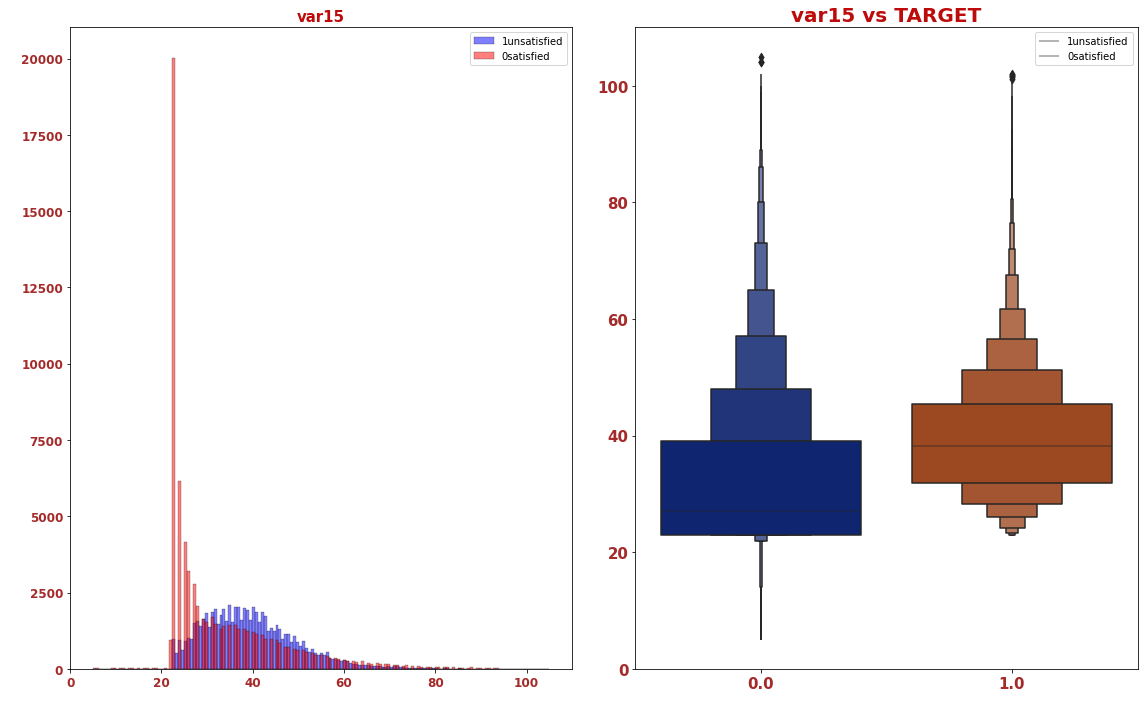

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","var15")

1. here we make some assumptions based on the "var15" value. more unsatisfied customers having their value is between the 20-40.
2. from this plot suppose the "var15" value is between the 20-40 then there is more chance to the customer is satisfied. 
3.if the customer "var15" value is more than 40-60 then there is more chance to the customer is unsatisfied.
4.so this "var15" feature helps to our classification to give atleast some basic intution.

In [ ]:
dataframe_train["var36"].describe()

count    146004.000000
mean         53.394343
std          46.495348
min           0.000000
25%           3.000000
50%          75.411808
75%          99.000000
max          99.000000
Name: var36, dtype: float64

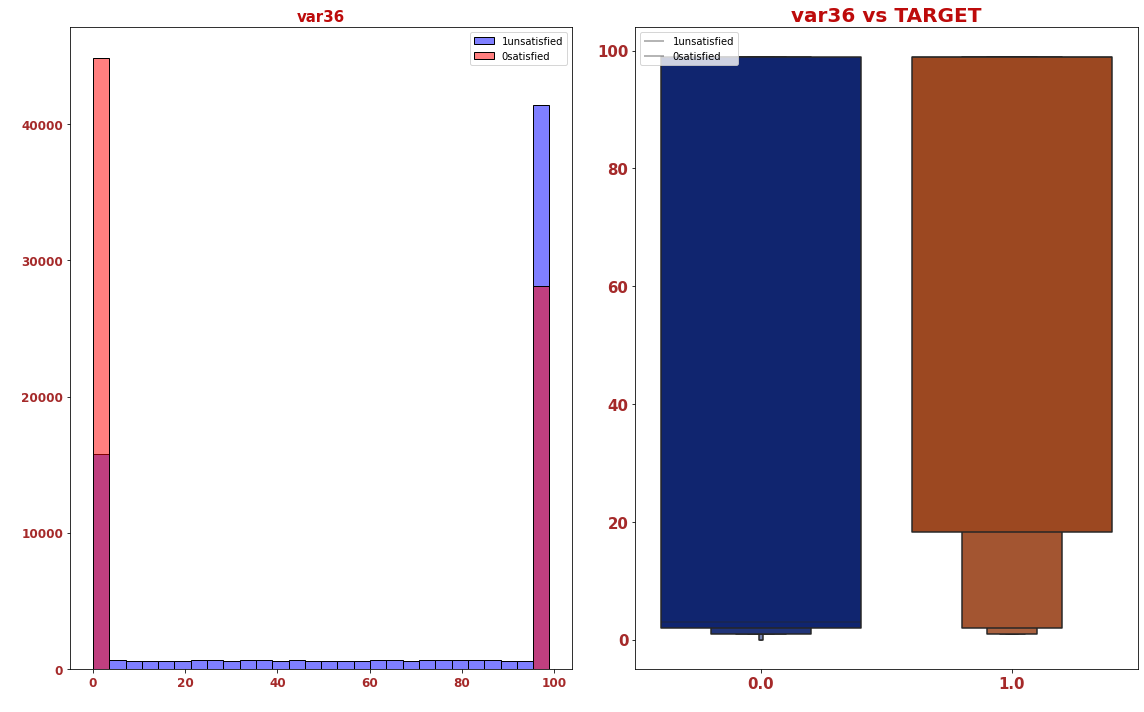

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","var36")

<pre>
Observation:
1.if the "var36" value is between the 0-20 then there is higher chances to become the customer is Satisfied. 
</pre>

In [ ]:
def columndistribution_with_log_target(df,target,col):
  """
    histogramplot:
  """
  plt.figure(figsize=(16,10))
  plt.subplot(1,2,1)
  sns.histplot(x=np.log(df[col]),data=df,hue="TARGET")
  plt.xticks(rotation = 0)
  plt.title(col, fontsize = 15, fontweight = 'bold', color = '#bd0b0b')
  plt.xlabel(" ")
  plt.ylabel("count")
  plt.legend(["1unsatisfied","0satisfied"])
  plt.xticks(fontsize = 12, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 12, fontweight = 'bold', color = 'brown')
  plt.tight_layout()
  """
  boxenplot:
           Boxenplots (actually called letter-value plots in the original paper )
            show the distribution differently and are better for bigger datasets.
            Classic boxplots can have too many outliers and don't show as much information about the distribution.
  """
  plt.subplot(1,2,2)
  sns.boxenplot(x = target,y = np.log(df[col]),  data = df,palette = 'dark')
  plt.xticks(rotation = 0)
  plt.title(f'{col} vs {target}', fontsize = 20, fontweight = 'bold', color = '#bd0b0b')
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.legend(["1unsatisfied","0satisfied"])
  plt.xticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 15, fontweight = 'bold', color = 'brown')
  plt.tight_layout()

  plt.show()

In [ ]:
#columndistribution_with_target(dataframe_train,"TARGET","var38") # there is no use that's why plot the logscale

In [ ]:
dataframe_train['var38'].describe()

count    1.460040e+05
mean     1.088293e+05
std      1.461850e+05
min      5.163750e+03
25%      6.229221e+04
50%      9.660739e+04
75%      1.173110e+05
max      2.203474e+07
Name: var38, dtype: float64

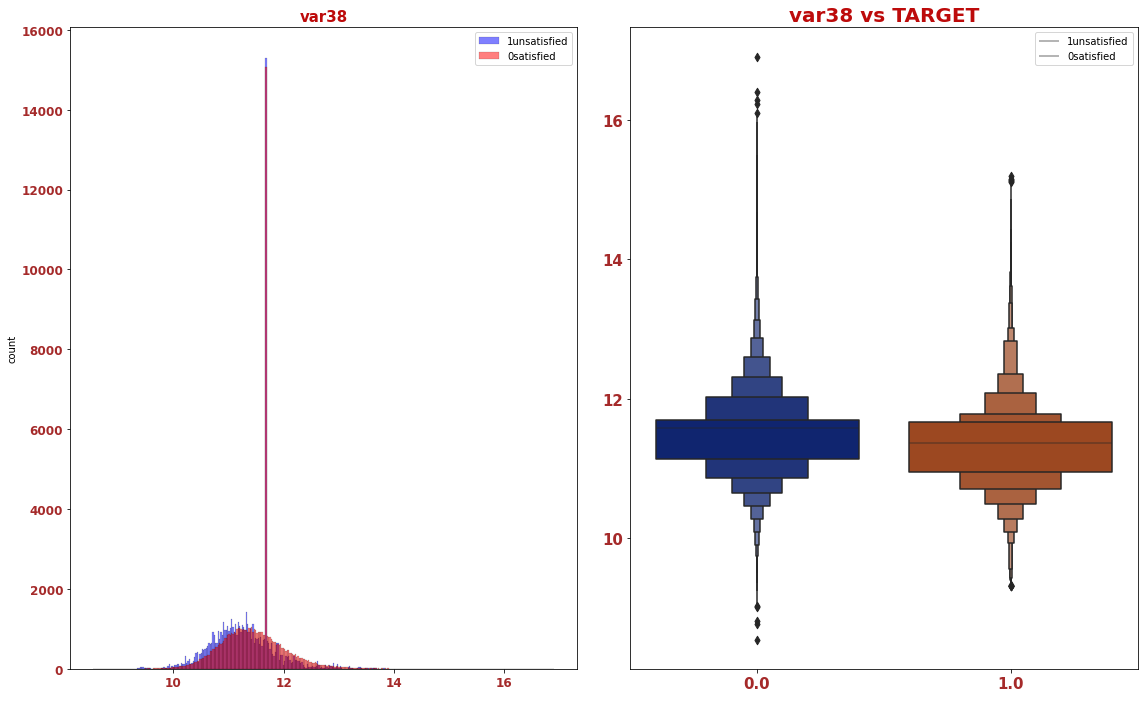

In [ ]:
columndistribution_with_log_target(dataframe_train,"TARGET","var38")

<pre>
1.most of the unsatisfied customers "var38" value is 
</pre>

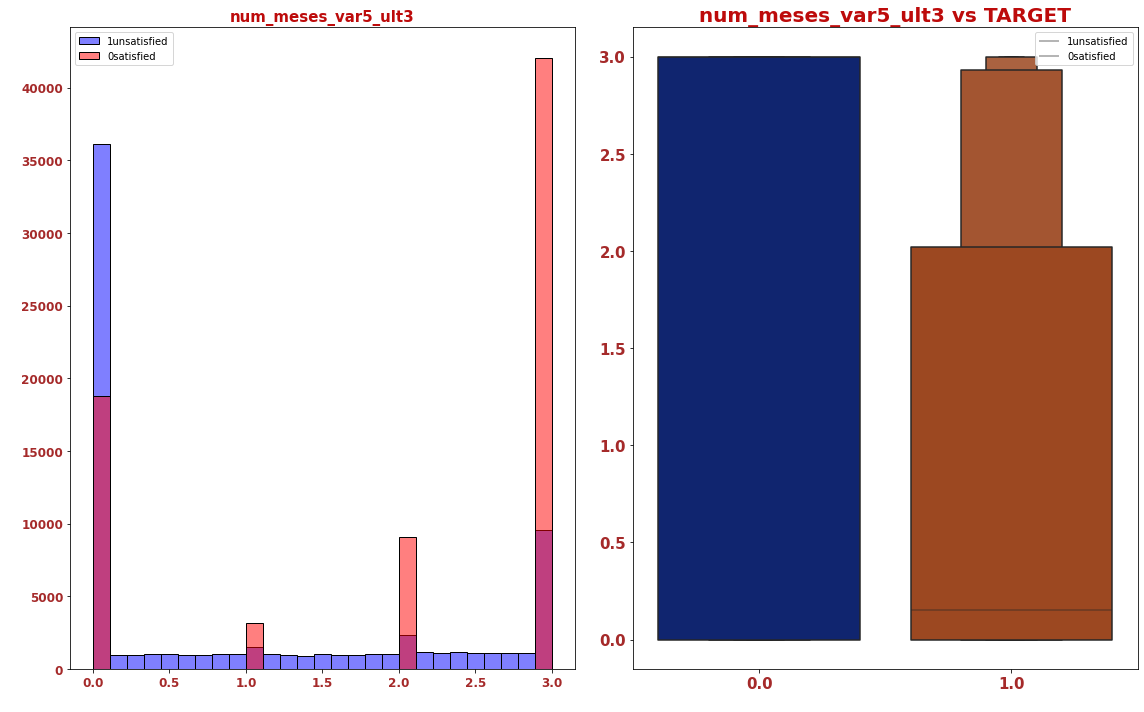

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","num_meses_var5_ult3")

<pre>
1.if the value is zero then there is most of the chance to the customer becomes the unsatisfied customer.
2.if the value is 1 then there is equal chance to the customer is satisfied and unsatisfied.
3.if the value is morethan 2 then there is high chance to the customer is satisfied than the unsaisfied customers.
4.so this column is useful for our classification.
</pre>

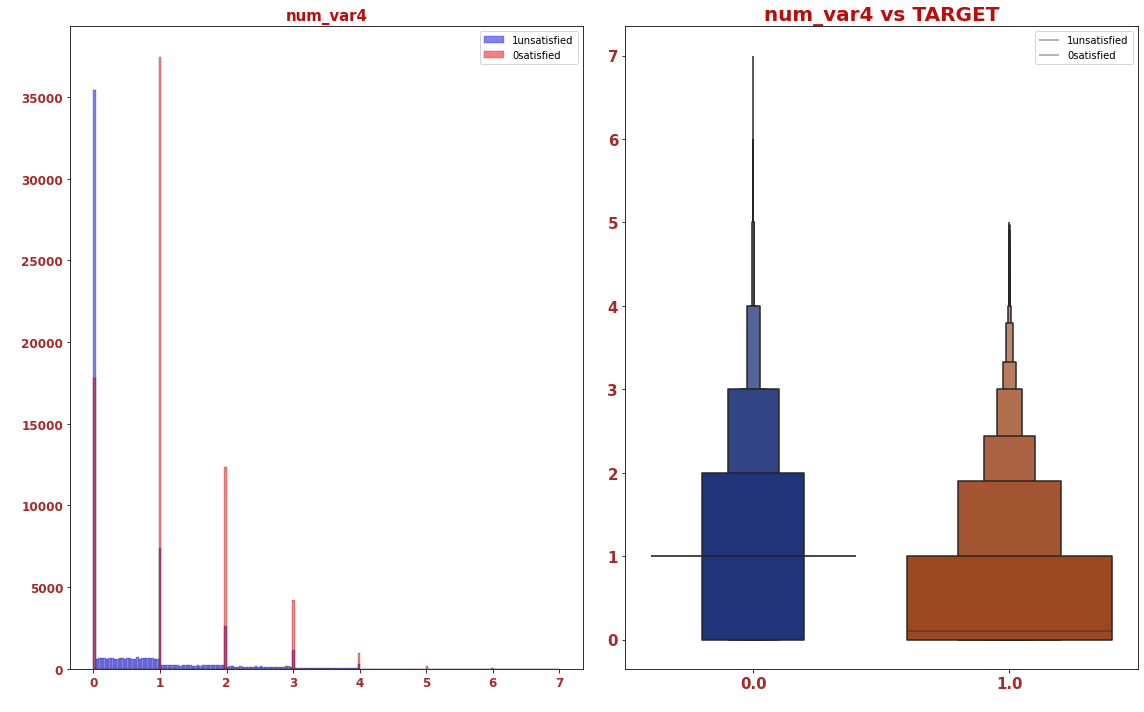

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","num_var4")

<pre>
1.if the num_var4 value is 1 then the most possibility is the customer is satisfied.around >35k unsatisfied points having value is 1 .
2.if the value is 0 then there is more chance to the customer is satisfied around 35k customers are unsatisfied and around 18k customers are satisfied.
3.if the value is between 0-1 then there is more chance to the customer is unsatisfied. and if the value is 1-2 then there is equal chance to the customer is satisfied or unsatisfied.
4.if the value is greater than 2 most possibility is customer becomes satisfied than unsatisfied.
</pre>

In [ ]:
#columndistribution_with_target(dataframe_train,"TARGET","num_var45_ult3") # interpretation is hard to under stand so draw the log-scale.

In [ ]:
dataframe_train["num_var45_ult3"].describe()

count    146004.000000
mean         12.703433
std          32.013442
min           0.000000
25%           0.000000
50%           1.373101
75%          11.114578
max         801.000000
Name: num_var45_ult3, dtype: float64

In [ ]:
#feature_outlier_analysis(dataframe_train,"num_var45_ult3")

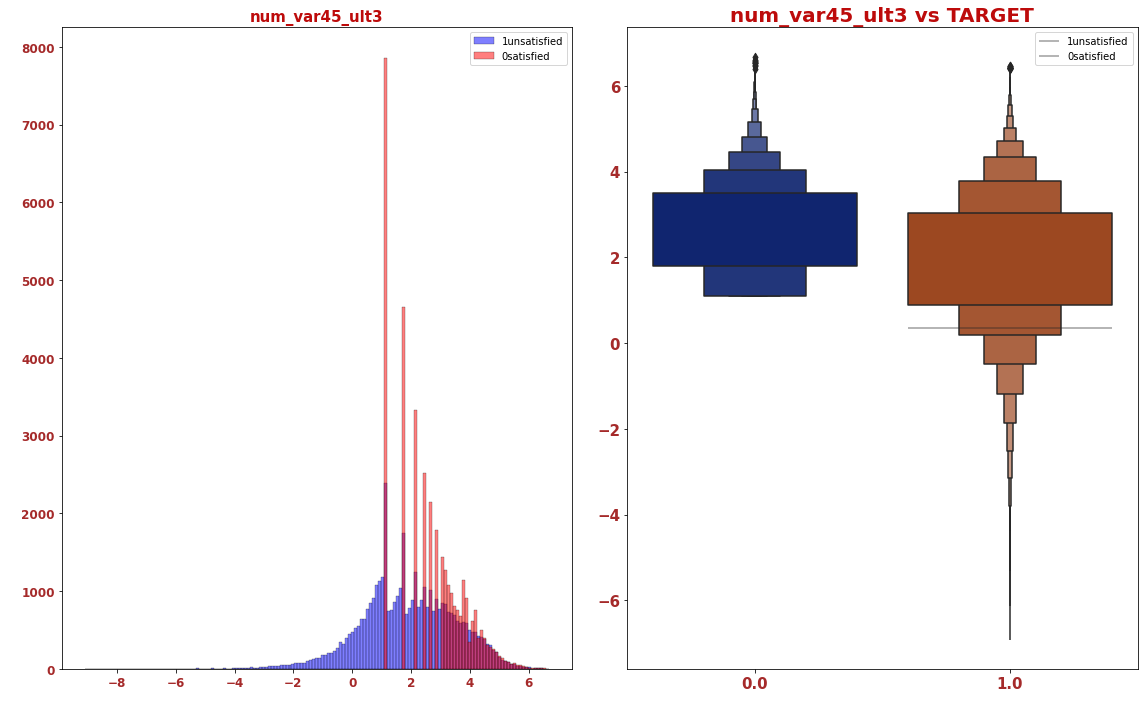

In [ ]:
columndistribution_with_log_target(dataframe_train,"TARGET","num_var45_ult3")

<pre>
1.if the "num_var45_ult3" is lessthan
</pre>

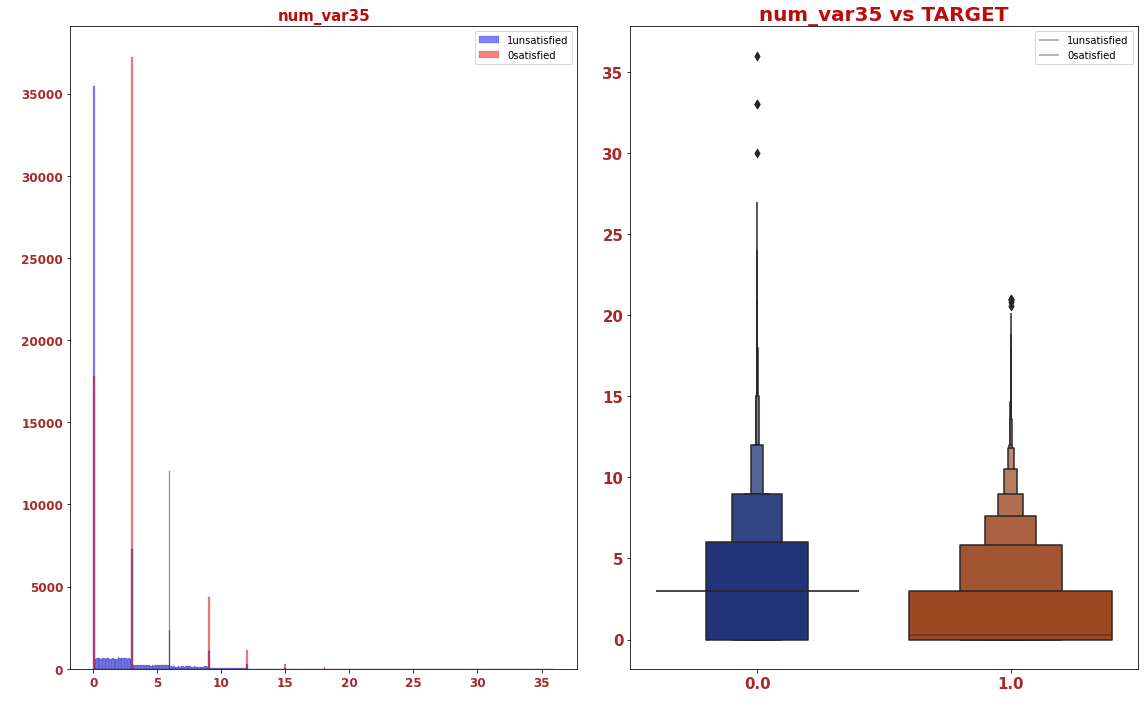

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","num_var35")

<pre>
1. if the value is 3 then most possibility is the customer is satisfied than the unsatisfied  customer and most of the the satisfied customer having their num_var35 is value is 3.

2.most of the unsatisfied customers having their value is 0.
3.so it is useful to our classification.

</pre>

In [ ]:
dataframe_train["ind_var5"].describe()

count    146004.000000
mean          0.503439
std           0.476291
min           0.000000
25%           0.000000
50%           0.527149
75%           1.000000
max           1.000000
Name: ind_var5, dtype: float64

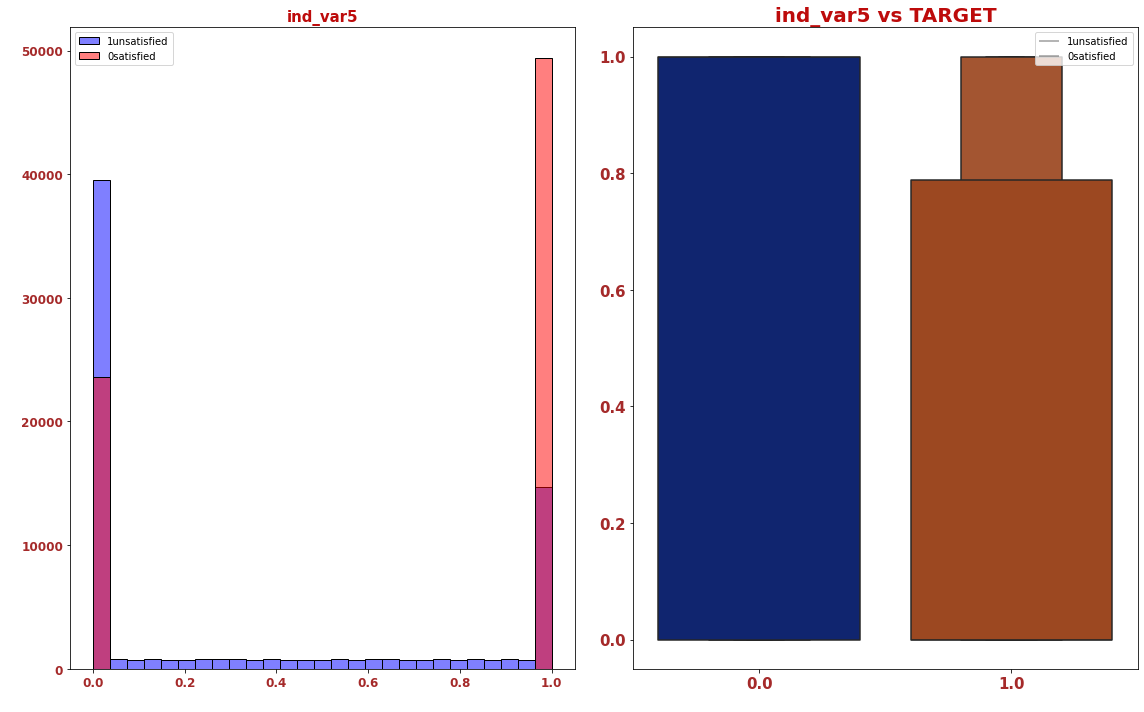

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","ind_var5")

<pre>
1.if ind_var5 value is 1 then there is most possibility to the customer is satisfied .
2. if ind_var5 value is 0 then there is most possibility to the customer is unsatisfied.
3.it is also useful to our classification.

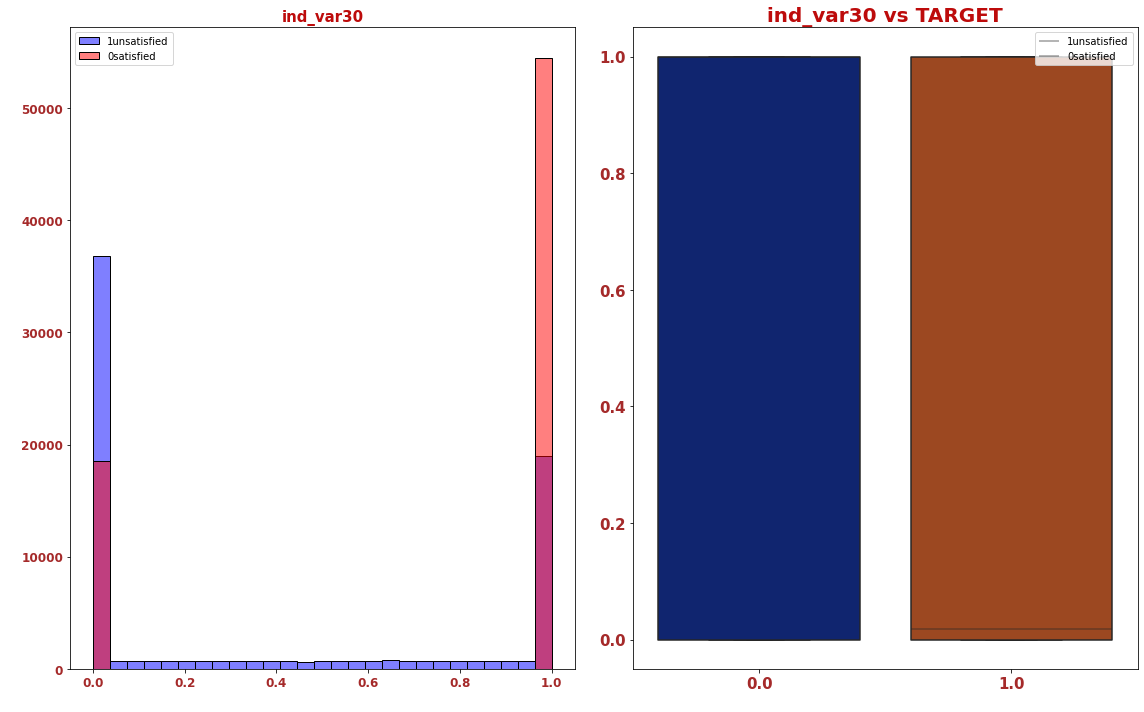

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","ind_var30")

<pre>
Observation:
1.if the value is 1 then littlebit higher chance to the customer is satisfied. and if the value is 0 then there is little bit higher chance to the customer is unsatisfied.
</pre>

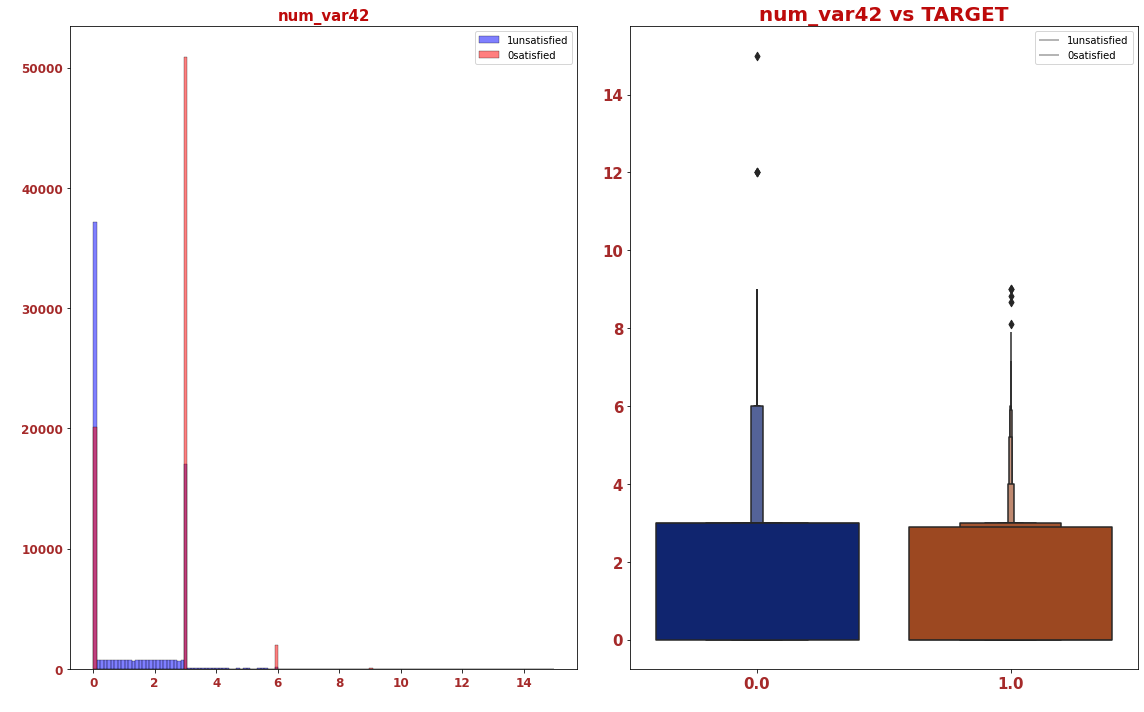

In [ ]:
columndistribution_with_target(dataframe_train,"TARGET","num_var42")

<pre>
1.morethan 35k unsatisfied customers having their value is 0 and 20k satisfied customers having their value is 0.
2.morethan 50k satisfied customers having their value is 3 and morethan 15k unsatisfied customers having their value is 3.
3.get some basic intution but not clearly.
</pre>

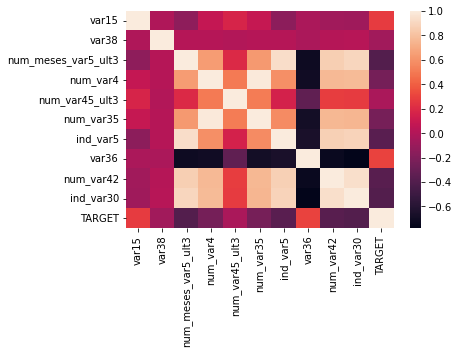

In [ ]:
top = top_picked_features.columns[:10].to_list()
top
top.append("TARGET")

a=dataframe_train[top].corr()
sns.heatmap(a)
plt.show()

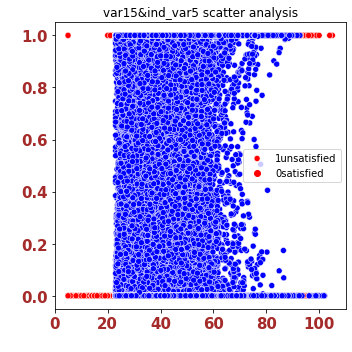

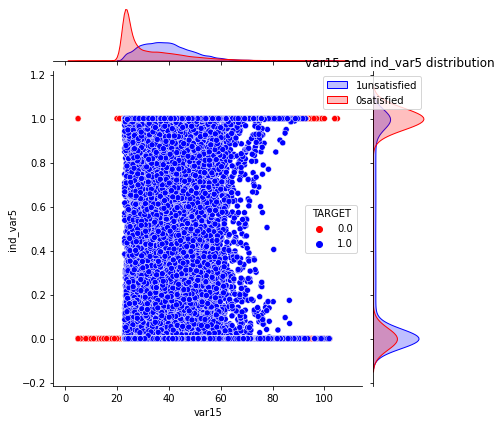

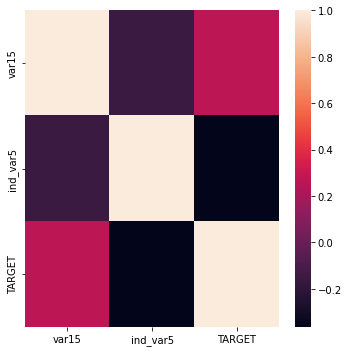

In [ ]:
bivariate_analysis2(dataframe_train,"TARGET","var15","ind_var5")

In [ ]:
#observation:
#1. finally I got "var15" irrespective of the any column if the value is less than 23(approx) customer is satisfied mostly.
#2. and between the 23-80(approx) mostly those are unsatisfied .

In [ ]:
cate=['num_var20_0', 'num_meses_var13_largo_ult3', 'num_var20'] # taken based on the no of unique columns.

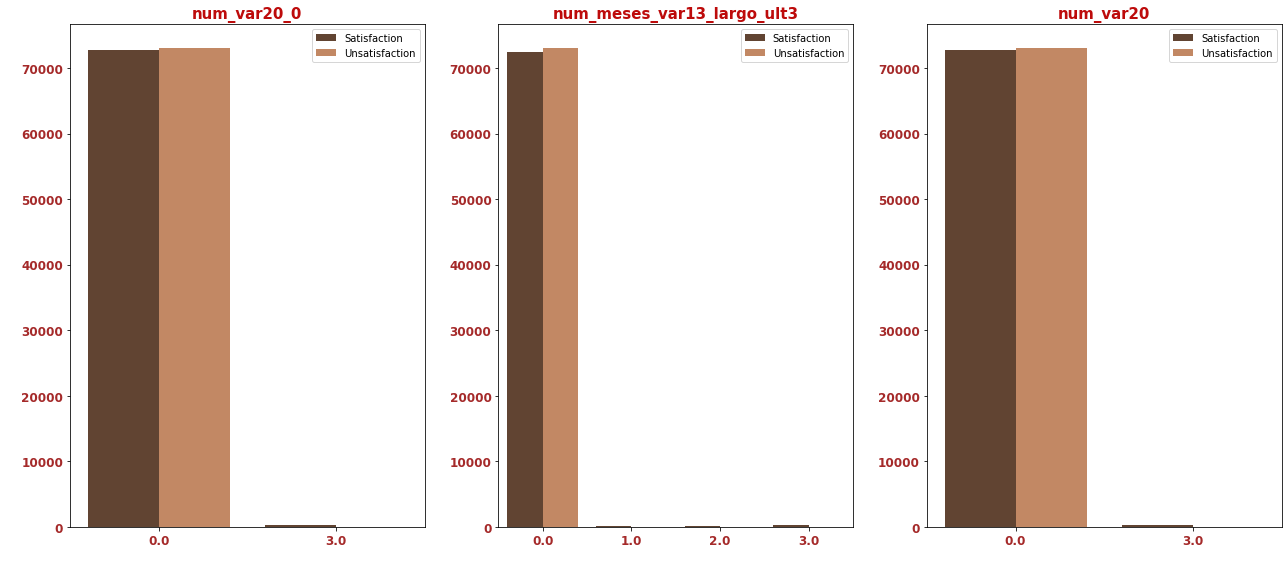

In [ ]:
plt.figure(figsize = (18,8))

for i,col in enumerate(cate):
  plt.subplot(1,3,i+1)
  sns.countplot(x = col,  data = dataframe_train, palette='copper', hue = 'TARGET' )
  plt.xticks(rotation = 0)
  plt.title(col, fontsize = 15, fontweight = 'bold', color = '#bd0b0b')
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.legend(['Satisfaction', 'Unsatisfaction'])
  plt.xticks(fontsize = 12, fontweight = 'bold', color = 'brown')
  plt.yticks(fontsize = 12, fontweight = 'bold', color = 'brown')
  plt.tight_layout()

<pre>
1.50-50 cahances if the value is 0 of those customers
2. we need to check what are the possibility if the value is other than zero. is it satisfied or unsatisfied.
3. so this type of columns having the low feature importances and I didn't consider those type of features.
</pre>

## AUC

<pre>
AUC-ROC curve helps us visualize how well our machine learning classifier is performing
1. accuracy we shouldn't use accuracy as  ametric on imbalanced dataset.
incase we are using accuaracy as metric it is easy to get a high score by simply classifying all observations are considered as the majority class.

accuracy measures how many observations are correctly classified whatever class/label it is.

if your problem is balanced and you care about both positive and negative predictions, accuracy is a good choice because it is really simple and easy to interpret.


2. F1-score:
           it is the harmonic mean of the precision and recall and these are calculated on the predicted classes/labels not on prediction scores.
incase we are using f1score as metric we need to find the obtimized threshold value . based on threshold value changed the f1-score a lot 

F1 score is balancing precision and recall on the positive class 

3.PR-AUC:
        What is different however is that ROC AUC looks at a true positive rate TPR and false positive rate FPR while PR AUC looks at positive predictive value PPV and true positive rate TPR.
if you care more about the positive class, then using PR AUC.

If your dataset is heavily imbalanced and/or you mostly care about the positive class, I’d consider using F1 score, or Precision-Recall curve and PR AUC.

3. AUC-ROC:
          AUC-ROC curve is a area under the Reciever Operating characteristic curve. AUC-Roc is aperformance measurement for the classification problem at various threshold values.
ROC is a probability curve & AUC  represents the degree of measure of seperability and it tells how much a model is capable of distinguishing between classes.

ROC AUC is especially good at ranking predictions. Because of that, if you have a problem where sorting your observations is what you care about ROC AUC is likely what you are looking for.

if you care about ranking predictions, don’t need them to be properly calibrated probabilities, and your dataset is not heavily imbalanced then I would go with ROC AUC.

So, if you care about ranking predictions, don’t need them to be properly calibrated probabilities, and your dataset is not heavily imbalanced then I would go with ROC AUC.

So here we are concentrate on both classes . so here we need to consider ranking predections and it is heavily imbalanced so by using SMOTE technique balancing  the dataset.

<a href=https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc>for more details</a>
</pre>